In [1]:
# @title Library Import
print("Importing Libraries")
import sys
!pip install boto3
import boto3
import argparse
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.ndimage import gaussian_filter
from io import BytesIO
import re
import requests


import pandas as pd
import numpy as np

import matplotlib as plt
import matplotlib.pyplot as plt


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install windrose
from windrose import WindroseAxes
from matplotlib.colors import ListedColormap


print("Mounting Google Drive")
from google.colab import drive
drive.mount('/content/drive')

print("Finished Importing")

Importing Libraries
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.0 MB/s eta 0:00:00
Mounting Google Drive
Mounted at /content/drive
Finished Importing


In [20]:
# @title Insert site ICAO (kyyy) as well as start and end dates
site = 'khaf'
start_api = '201001011200'
end_api = '202407311200'

In [21]:
# @title Use Synoptic API to fetch archived data and export for later analysis


# Define the URL and parameters from the Synoptic API
url = "https://api.synopticdata.com/v2/stations/timeseries"

params = {
    'token': 'd8c6aee36a994f90857925cea26934be',
    'stid':  f'{site}',
    'units': 'english',
    'start': f'{start_api}',
    'end':   f'{end_api}',
    'network': '1'
}

site_id = params.get('stid')
start_date = params.get('start')
end_date = params.get('end')
print(f"Getting archived data for {site.upper()}")



# Make the HTTP request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Get the JSON data
    data = response.json()

    # Extract the list of stations
    stations = data.get('STATION', [])

    # Create a dictionary to hold DataFrames for each station
    station_dfs = {}

    # Process each station's data
    for station in stations:
        stid = station.get('STID')
        name = station.get('NAME')
        latitude = station.get('LATITUDE')
        longitude = station.get('LONGITUDE')
        elevation = station.get('ELEVATION')
        observations = station.get('OBSERVATIONS', {})

        # Convert the observations into a DataFrame
        df = pd.DataFrame(observations)

        # Convert 'date_time' column to datetime format
        df['date_time'] = pd.to_datetime(df['date_time'])

        # Convert wind-related columns from knots to mph if they exist
        wind_columns = ['wind_speed_mph', 'pk_gust_mph', 'pk_wind_mph']
        for wind_column in wind_columns:
            if wind_column in df.columns:
                # Fill NaNs with 0 or another appropriate value if needed
                df[wind_column] = df[wind_column].fillna(0)
                # Convert from knots to mph, round, and convert to integer
                df[wind_column] = (df[wind_column] * 1.15078).round().astype(int)

        # Add the station ID, latitude, longitude, and elevation as new columns
        df['STID'] = stid
        df['LATITUDE'] = latitude
        df['LONGITUDE'] = longitude
        df['ELEVATION'] = elevation
        df['NAME'] = name
        df['NAME'] = df['NAME'].str.title().str.replace('-', ' ')

        # Convert 'date_time' column to datetime format if it exists
        if 'date_time' in df.columns:
            df['date_time'] = pd.to_datetime(df['date_time'])

        # Store the DataFrame in the dictionary with station ID as the key
        station_dfs[stid] = df

        # Optionally, print the DataFrame for each station
        # print(f"Data for station {stid}:")
        # print(df.head())
        # print("\n")


    # If needed, combine all DataFrames into a single DataFrame (example)
    # combined_df = pd.concat(station_dfs.values(), keys=station_dfs.keys())
    data_start = station_dfs[site_id.upper()]['date_time'].dt.year.min()
    data_end   = station_dfs[site_id.upper()]['date_time'].dt.year.min()
    print(f"Data extraction complete and archived data from {site_id.upper()} is avaiable. Data availability is",
          f"from {df['date_time'].dt.year.min()} to {df['date_time'].dt.year.max()}")

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")


# List of columns to keep
columns_to_keep = [
    'date_time', 'visibility_set_1', 'air_temp_set_1', 'sea_level_pressure_set_1d',
    'ceiling_set_1', 'STID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME',
    'weather_cond_code_set_1', 'dew_point_temperature_set_1d'
]

# Identify columns related to winds (excluding wind chill)
wind_columns = [col for col in station_dfs[site_id.upper()].columns if 'wind' in col and 'wind_chill' not in col]

# Identify columns related to relative humidity
rh_columns = [col for col in station_dfs[site_id.upper()].columns if 'relative_humidity' in col]

# Combine all columns to keep
columns_to_keep += wind_columns + rh_columns


# Make an explicit copy of the DataFrame to avoid the SettingWithCopyWarning
station_df = station_dfs[site_id.upper()][columns_to_keep].copy()

# Rename columns
station_df.rename(columns={
    'air_temp_set_1': 'tempf',
    'dew_point_temperature_set_1d': 'dewptf',
    'relative_humidity_set_1': 'rh',
    'wind_speed_set_1': 'sus_wind',
    'wind_direction_set_1': 'sus_wind_dir',
    'wind_gust_set_1': 'pk_gust',
    'wind_cardinal_direction_set_1d': 'card_wind_dir',
    'peak_wind_speed_set_1': 'pk_wind',
    'sea_level_pressure_set_1d': 'mslp',
    'LONGITUDE': 'longitude',
    'LATITUDE': 'latitude',
    'ELEVATION': 'elevation',
    'NAME': 'name',
    'STID': 'station',
    'date_time': 'date',
    'visibility_set_1': 'visibility',
    'ceiling_set_1': 'ceiling',
    'weather_cond_code_set_1': 'wxcode'
}, inplace=True)

# Convert object columns to numeric, where applicable
columns_to_convert = ['latitude', 'longitude', 'elevation']

for col in columns_to_convert:
    station_df[col] = pd.to_numeric(station_df[col], errors='coerce')


#Reorganize things and specify the columns you want in the desired order
desired_columns = ['station', 'name', 'latitude', 'longitude', 'elevation', 'tempf',
                   'dewptf', 'rh', 'sus_wind', 'sus_wind_dir', 'pk_gust', 'wxcode']

# Get the remaining columns that are not in the desired_columns list
remaining_columns = [col for col in station_df.columns if col not in desired_columns]

# Rearrange the DataFrame columns and assign it back to station_df
station_df = station_df[desired_columns + remaining_columns]

def calculate_dewpoint_depression(df):
    # Check if both 'tempf' and 'dewptf' columns exist
    if 'tempf' in df.columns and 'dewptf' in df.columns:
        # Convert columns to numeric if necessary, and handle errors by setting invalid values to NaN
        df['tempf'] = pd.to_numeric(df['tempf'], errors='coerce')
        df['dewptf'] = pd.to_numeric(df['dewptf'], errors='coerce')

        # Calculate dewpoint depression and handle missing values
        df['dewpt_dep'] = np.where(df['tempf'].isna() | df['dewptf'].isna(), np.nan, df['tempf'] - df['dewptf'])

        print("Dewpoint depression calculated, missing values handled.")
    else:
        print("Error: 'tempf' or 'dewptf' column is missing in the DataFrame.")

# Calculate dewpoint depression for the main DataFrame
calculate_dewpoint_depression(station_df)


# Verify the conversion
station_df.head()
print(f'Exporting archived metar data for {site.upper()}')
output_file = f'/content/drive/MyDrive/metar_archive/{site}/txt/{site}_archived_data.csv'
#station_df.to_csv(output_file, index="False")

print(f"Data exported and reorgnized for {site_id.upper()} archived data from {station_df['date'].dt.year.min()} to {station_df['date'].dt.year.max()}")


Getting archived data for KHAF
Data extraction complete and archived data from KHAF is avaiable. Data availability is from 2010 to 2024
Dewpoint depression calculated, missing values handled.
Exporting archived metar data for KHAF
Data exported and reorgnized for KHAF archived data from 2010 to 2024


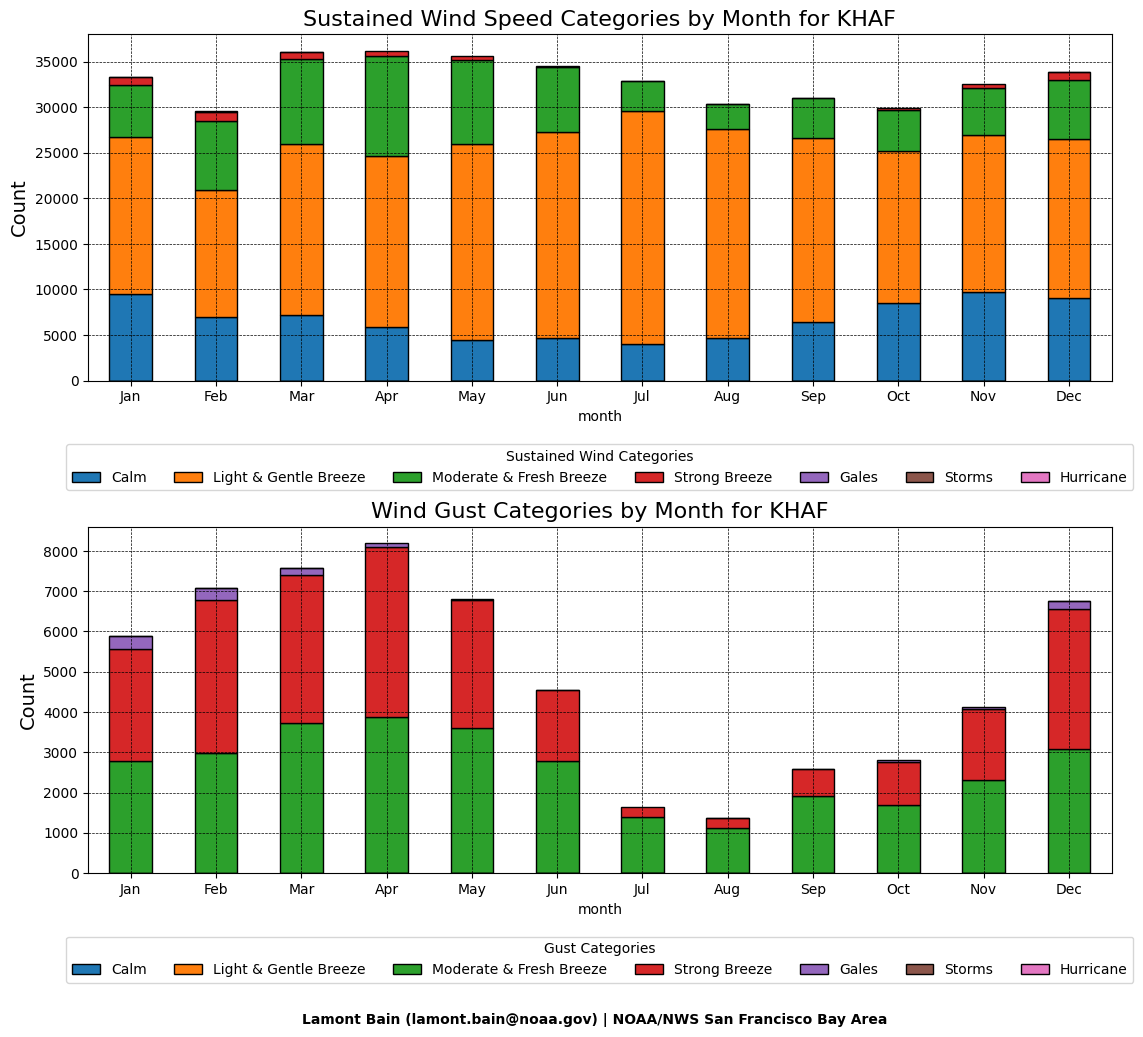

Monthly frequency plots saved to /content/drive/MyDrive/metar_archive/khaf/img/wind/monthly/khaf_monthly_frequency_winds.png


In [22]:
# @title Wind and Wind Gust Magnitude by Month
station_df['sus_wind']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define categories and corresponding wind speed ranges (in knots)
wind_categories = {
    'Calm': (0, 0.9),
    'Light & Gentle Breeze': (1, 10),
    'Moderate & Fresh Breeze': (10, 20),
    'Strong Breeze': (20, 33),
    'Gales': (34, 47),
    'Storms': (48, 63),
    'Hurricane': (63, np.inf)
}

# Function to bin data based on the categories
def bin_wind_data(df, wind_col, gust_col):
    """
    Bin the wind and gust data into predefined categories.

    Parameters:
    - df: DataFrame containing wind and gust data.
    - wind_col: Column name for sustained wind speeds.
    - gust_col: Column name for gust wind speeds.

    Returns:
    - DataFrame with binned wind and gust data, including month info.
    """
    # Define new columns for wind and gust categories
    df['sus_wind_category'] = pd.cut(df[wind_col],
                                     bins=[v[0] for v in wind_categories.values()] + [np.inf],
                                     labels=list(wind_categories.keys()),
                                     right=False)

    df['pk_gust_category'] = pd.cut(df[gust_col],
                                    bins=[v[0] for v in wind_categories.values()] + [np.inf],
                                    labels=list(wind_categories.keys()),
                                    right=False)

    # Add a 'month' column
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.strftime('%b')

    return df

# Bin the wind and gust data
binned_df = bin_wind_data(station_df, wind_col='sus_wind', gust_col='pk_gust')

# Function to get counts per month and wind category
def get_monthly_counts(df):
    """
    Calculate the counts of each wind and gust category by month.

    Returns:
    - DataFrames with counts for sustained wind and gust.
    """
    sus_wind_counts = df.groupby(['month', 'sus_wind_category'], observed=False).size().unstack(fill_value=0)
    gust_counts = df.groupby(['month', 'pk_gust_category'], observed=False).size().unstack(fill_value=0)

    return sus_wind_counts, gust_counts

# Get the counts per month
sus_wind_counts, gust_counts = get_monthly_counts(binned_df)



def plot_stacked_bar(sus_wind_counts, gust_counts):
    # Create the figure and axes for the plots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=False)

    # Calculate the maximum values from both datasets to set dynamic ylim
    max_sus_wind = sus_wind_counts.sum(axis=1).max()  # Maximum of the stacked bars for sustained wind
    max_gusts = gust_counts.sum(axis=1).max()  # Maximum of the stacked bars for gusts
    buffer = 0.05  # Adding a 5% buffer

    # Plot for Sustained Wind
    sus_wind_counts.plot(kind='bar', stacked=True, ax=axes[0], lw=1, edgecolor='black')
    axes[0].set_title(f'Sustained Wind Speed Categories by Month for {site.upper()}', fontsize=16)
    axes[0].set_ylabel('Count', fontsize=14)
    axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                             rotation=0)
    axes[0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

    # Dynamically set ylim for Sustained Wind with a buffer
    axes[0].set_ylim(0, max_sus_wind + max_sus_wind * buffer)

    # Place legend below the first plot, adjust anchor to prevent overlap
    axes[0].legend(title='Sustained Wind Categories', bbox_to_anchor=(0.5, -0.25), loc='center', fontsize=10, ncol=7)

    # Plot for Gusts
    gust_counts.plot(kind='bar', stacked=True, ax=axes[1], lw=1, edgecolor='black')
    axes[1].set_title(f'Wind Gust Categories by Month for {site.upper()}', fontsize=16)
    axes[1].set_ylabel('Count', fontsize=14)
    axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                             rotation=0)
    axes[1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

    # Dynamically set ylim for Gusts with a buffer
    axes[1].set_ylim(0, max_gusts + max_gusts * buffer)

    # Place legend below the second plot, adjust anchor to prevent overlap
    axes[1].legend(title='Gust Categories', bbox_to_anchor=(0.5, -0.25), loc='center', fontsize=10, ncol=7)

    # Adjust layout to add space between the plots and the legends
    fig.subplots_adjust(hspace=0.3)


    # Adjust layout for better spacing
    plt.tight_layout()

    bottom_legend = axes[1].get_legend()  # Assuming axes[1] is your bottom subplot
    legend_bbox = bottom_legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

    # Calculate the y-coordinate for the text
    text_y = -0.15 + legend_bbox.y0  # Adjust the 0.05 for desired spacing

    # Place the text using fig.text
    fig.text(0.5, text_y, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area',
            ha='center', fontsize=10, fontweight='bold', transform=fig.transFigure)

    #plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
    save_path = f'/content/drive/MyDrive/metar_archive/{site}/img/wind/monthly/'
    save_filename = f'{save_path}{site}_monthly_frequency_winds.png'
    plt.savefig(save_filename)
    plt.show()
    print(f"Monthly frequency plots saved to {save_filename}")



# Call the function with the monthly counts
plot_stacked_bar(sus_wind_counts, gust_counts)

<Figure size 640x480 with 0 Axes>

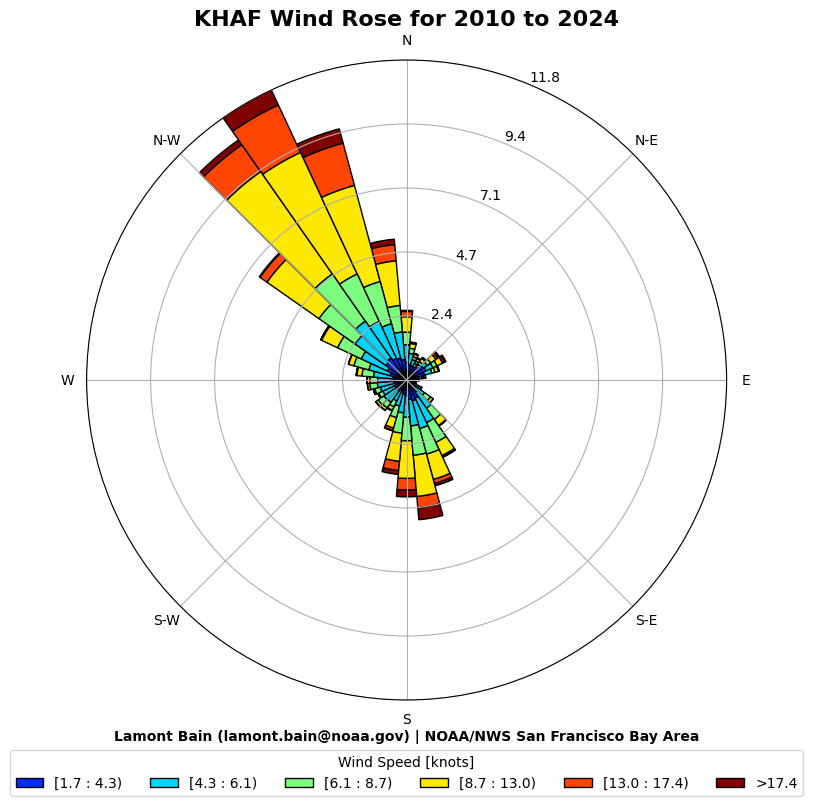

In [23]:
# @title Generate Wind Rose (All Time & By Month)



# Define wind speed categories and corresponding bins in knots (excluding Calm)
wind_categories = {
    '1': (1.738, 4.256),  # 2.0-4.9 mph
    '2': (4.348, 5.995),  # 5.0-6.9 mph
    '3': (6.086, 8.598),  # 7.0-9.9 mph
    '4': (8.689, 12.945),  # 10.0-14.9 mph
    '5': (13.037, 17.294),  # 15.0-19.9 mph
    '6': (17.386, np.inf)  # 20.0+ mph
}

wind_bins = np.array([min_speed for _, (min_speed, max_speed) in wind_categories.items()])

# Filter the DataFrame for rows where sus_wind is above the threshold (in knots)
#filtered_df = None
filtered_df = station_df.query('sus_wind > 1.737').dropna(subset=['sus_wind', 'sus_wind_dir'])


'''
    1: "Moderate Rain",
    2: "Moderate Drizzle",
    3: "Moderate Snow",
    5: "Thunder",
    6: "Haze",
    7: "Smoke",
    8: "Dust",
    9: "Fog",
    13: "Light Rain",
    14: "Heavy Rain",
    17: "Light Drizzle",
    18: "Heavy Drizzle",
    28: "Light Thunder",
    29: "Heavy Thunder",
    31: "Mist",
    51: "Light Rain Shower",
    52: "Heavy Rain Shower"
'''


# Exclude specific weather codes
exclude_wxcodes = [1, 3, 13, 14, 28, 29, 51, 52]
filtered_df = filtered_df[~filtered_df['wxcode'].isin(exclude_wxcodes)]


#filtered_df = filtered_df[(filtered_df['date'].dt.hour >= 10) | (filtered_df['date'].dt.hour < 22)]

# Calculate the percentage of "Calm" winds (sus_wind <= 1.738 knots)
calm_percentage = (station_df['sus_wind'] <= 1.738).mean() * 100

# Create the wind rose plot for the filtered data
plt.clf()
fig = plt.figure(figsize=(8, 8))  # Set the overall plot size
ax = WindroseAxes(fig, [0.1, 0.1, 0.8, 0.8])  # Adjust the size and position of the windrose
fig.add_axes(ax)
#ax = WindroseAxes.from_ax(figsize=(8, 8))

# Define custom colors for each wind speed category (excluding Calm)
#color_list = ['navy','cyan', 'yellowgreen', 'yellow', 'orange', 'orangered', 'red', 'maroon']
#cmap = ListedColormap(color_list)


color_list = [
    '#012cff',  # RGB (1, 44, 255)
    '#00d5f7',  # RGB (0, 213, 247)
    '#7cfd7f',  # RGB (124, 253, 127)
    '#fde801',  # RGB (253, 232, 1)
    '#ff4503',  # RGB (255, 69, 3)
    '#7e0100'   # RGB (126, 1, 0)
]

# Create the ListedColormap
cmap = ListedColormap(color_list)


# Plot wind rose with custom speed bins and the defined colormap
ax.bar(filtered_df['sus_wind_dir'], filtered_df['sus_wind'],
       bins=wind_bins, normed=True, opening=1, edgecolor='black', nsector=36, cmap=cmap)

# Add legend and labels
wind_speed_labels = list(wind_categories.keys())
plt.legend(title='Wind Speed [knots]', bbox_to_anchor=(0.5, -0.15), loc='lower center', borderaxespad=0., ncol=6)
ax.set_title(f"{site_id.upper()} Wind Rose for {station_df['date'].dt.year.min()} to {station_df['date'].dt.year.max()}",
             fontweight='bold', fontsize=16)


#ALB Signature
fig.text(0.5, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

# Show the plot
plt.show()






Text(0.5, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area')

<Figure size 640x480 with 0 Axes>

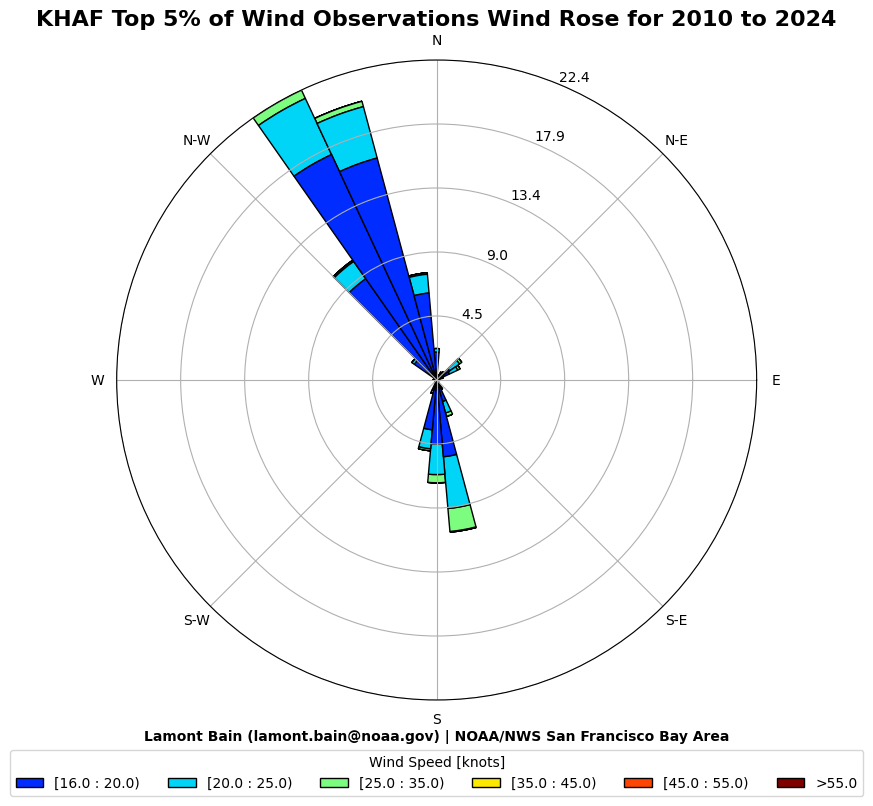

In [24]:
# @title Percentile Data of Wind Observations

# Calculate the 90th percentile of sustained wind, ignoring missing values

thresh_per = 0.95
threshold = filtered_df['sus_wind'].dropna().quantile(float(thresh_per))

# Filter the DataFrame to get the top 10% of wind events
top_x_percent_wind_events = filtered_df[filtered_df['sus_wind'] >= threshold]

# Create the wind rose plot for the filtered data
plt.clf()
fig = plt.figure(figsize=(8, 8))  # Set the overall plot size
ax = WindroseAxes(fig, [0.1, 0.1, 0.8, 0.8])  # Adjust the size and position of the windrose
fig.add_axes(ax)
#ax = WindroseAxes.from_ax(figsize=(8, 8))

# Define custom colors for each wind speed category (excluding Calm)
#color_list = ['navy','cyan', 'yellowgreen', 'yellow', 'orange', 'orangered', 'red', 'maroon']
#cmap = ListedColormap(color_list)

# Update wind_bins_strong to include the minimum wind speed
wind_bins_strong = {
    '1': (threshold,20),  # 2.0-4.9 mph
    '2': (20, 25),  # 5.0-6.9 mph
    '3': (25, 35),  # 7.0-9.9 mph
    '4': (35, 45),  # 10.0-14.9 mph
    '5': (45, 55),  # 15.0-19.9 mph
    '6': (55, np.inf)  # 20.0+ mph
}

wind_bins_strong = np.array([min_speed for _, (min_speed, max_speed) in wind_bins_strong.items()])

color_list = [
    '#012cff',  # RGB (1, 44, 255)
    '#00d5f7',  # RGB (0, 213, 247)
    '#7cfd7f',  # RGB (124, 253, 127)
    '#fde801',  # RGB (253, 232, 1)
    '#ff4503',  # RGB (255, 69, 3)
    '#7e0100'   # RGB (126, 1, 0)
]

# Create the ListedColormap
cmap = ListedColormap(color_list)


# Plot wind rose with custom speed bins and the defined colormap
ax.bar(top_x_percent_wind_events['sus_wind_dir'], top_x_percent_wind_events['sus_wind'],
       bins=wind_bins_strong, normed=True, opening=1, edgecolor='black', nsector=36, cmap=cmap)

# Add legend and labels
wind_speed_labels = list(wind_categories.keys())
plt.legend(title='Wind Speed [knots]', bbox_to_anchor=(0.5, -0.15), loc='lower center', borderaxespad=0., ncol=6)
ax.set_title(f"{site_id.upper()} Top {int(100-(thresh_per)*100)}% of Wind Observations Wind Rose for {station_df['date'].dt.year.min()} to {station_df['date'].dt.year.max()}",
             fontweight='bold', fontsize=16)


#ALB Signature
fig.text(0.5, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

# Show the plot
#plt.show()


In [25]:
# Create a new DataFrame with the selected columns and sorted values

# Print the formatted DataFrame without the index
#print(f"####-----COMPUTE TOP {int(100-(thresh_per)*100)}% OF WINDS AT {site.upper()}-----####")
#print(formatted_df)

In [26]:
# @title Experimental Stuff with Winds
'''

gales_df = binned_df[binned_df['sus_wind_category'] == 'Gales']['sus_wind_dir'].to_frame()
gales_df
gales_df = binned_df[binned_df['sus_wind_category'] == 'Gales']['sus_wind_dir'].to_frame()
gales_df

import matplotlib.pyplot as plt
import numpy as np
from windrose import WindroseAxes
from matplotlib.colors import ListedColormap

# Assuming binned_df is your DataFrame with 'sus_wind_category' and 'sus_wind_dir'

# Filter data for 'Gales' category
cat = 'Gales'
wind_cat_df = binned_df[binned_df['sus_wind_category'] == cat]

# Create a figure and axes for the plot
fig = plt.figure(figsize=(8, 8))
ax = WindroseAxes(fig, [0.1, 0.1, 0.8, 0.8])  # Adjust the size and position if needed
fig.add_axes(ax)

# Define custom colors if desired
# ...


color_list = [
    '#012cff',  # RGB (1, 44, 255)
    '#00d5f7',  # RGB (0, 213, 247)
    '#7cfd7f',  # RGB (124, 253, 127)
    '#fde801',  # RGB (253, 232, 1)
    '#ff4503',  # RGB (255, 69, 3)
    '#7e0100'   # RGB (126, 1, 0)
]

# Create the ListedColormap
cmap = ListedColormap(color_list)

# Define wind speed bins for 'Gales' category
# Adjust bins to include the minimum value for the 'Strong Breeze' category (20)
wind_bins_cat = np.array([20, 25, 30, 33])  # Adjust bins as needed


# Create the wind rose plot
ax.bar(wind_cat_df['sus_wind_dir'], wind_cat_df['sus_wind'],
       bins=wind_bins_cat,  # Use bins specific to 'Gales'
       normed=True,
       opening=0.8,
       edgecolor='black',
       cmap=cmap)  # Apply custom colors if defined

# Add legend, title, and other customizations
ax.set_legend(title='Wind Speed (knots)', loc='best')
ax.set_title(f'Wind Rose for {cat} Wind Category at {site.upper()}', fontweight='bold')
# ... (add other customizations as needed)
fig.text(0.5, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')


plt.show()
'''

"\n\ngales_df = binned_df[binned_df['sus_wind_category'] == 'Gales']['sus_wind_dir'].to_frame()\ngales_df\ngales_df = binned_df[binned_df['sus_wind_category'] == 'Gales']['sus_wind_dir'].to_frame()\ngales_df\n\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom windrose import WindroseAxes\nfrom matplotlib.colors import ListedColormap\n\n# Assuming binned_df is your DataFrame with 'sus_wind_category' and 'sus_wind_dir'\n\n# Filter data for 'Gales' category\ncat = 'Gales'\nwind_cat_df = binned_df[binned_df['sus_wind_category'] == cat]\n\n# Create a figure and axes for the plot\nfig = plt.figure(figsize=(8, 8))\nax = WindroseAxes(fig, [0.1, 0.1, 0.8, 0.8])  # Adjust the size and position if needed\nfig.add_axes(ax)\n\n# Define custom colors if desired\n# ...\n\n\ncolor_list = [\n    '#012cff',  # RGB (1, 44, 255)\n    '#00d5f7',  # RGB (0, 213, 247)\n    '#7cfd7f',  # RGB (124, 253, 127)\n    '#fde801',  # RGB (253, 232, 1)\n    '#ff4503',  # RGB (255, 69, 3)\n    '#7e0100'   # RG

<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

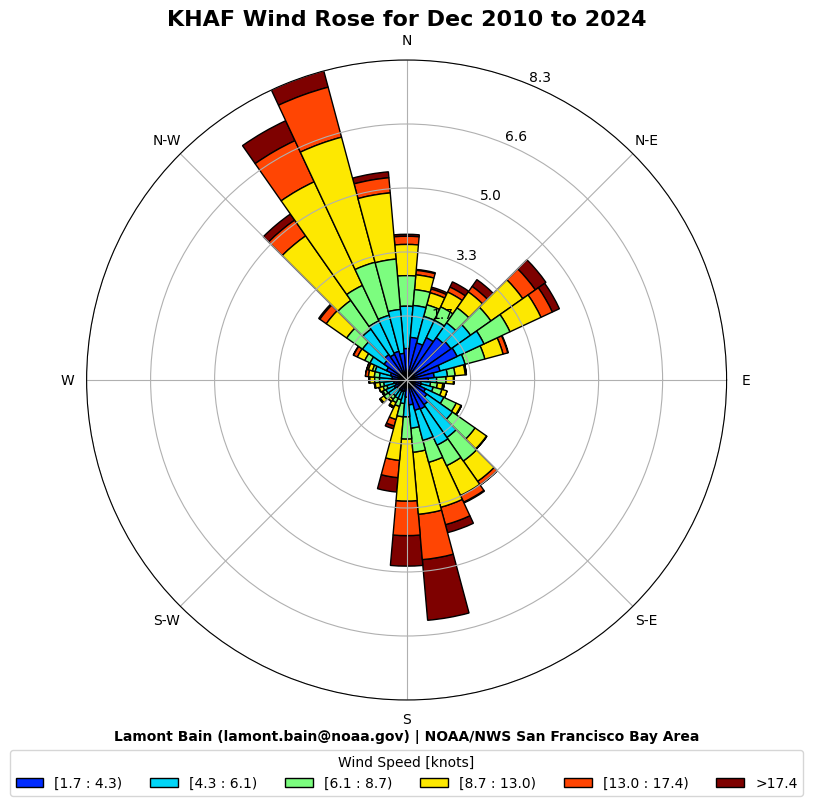

In [27]:
# @title Wind Rose By Month
# Define wind speed categories and corresponding bins in knots (excluding Calm)
wind_categories = {
    '1': (1.738, 4.256),  # 2.0-4.9 mph
    '2': (4.348, 5.995),  # 5.0-6.9 mph
    '3': (6.086, 8.598),  # 7.0-9.9 mph
    '4': (8.689, 12.945),  # 10.0-14.9 mph
    '5': (13.037, 17.294),  # 15.0-19.9 mph
    '6': (17.386, np.inf)  # 20.0+ mph
}

# Create wind bins from the categories
wind_bins = np.array([min_speed for _, (min_speed, max_speed) in wind_categories.items()])

# Filter the DataFrame for rows where sus_wind is above the threshold (in knots)
filtered_df = station_df.query('sus_wind > 1.737').dropna(subset=['sus_wind', 'sus_wind_dir'])



'''
    1: "Moderate Rain",
    2: "Moderate Drizzle",
    3: "Moderate Snow",
    5: "Thunder",
    6: "Haze",
    7: "Smoke",
    8: "Dust",
    9: "Fog",
    13: "Light Rain",
    14: "Heavy Rain",
    17: "Light Drizzle",
    18: "Heavy Drizzle",
    28: "Light Thunder",
    29: "Heavy Thunder",
    31: "Mist",
    51: "Light Rain Shower",
    52: "Heavy Rain Shower"
'''


# Exclude specific weather codes
exclude_wxcodes = [1, 3, 13, 14, 28, 29, 51, 52]
filtered_df = filtered_df[~filtered_df['wxcode'].isin(exclude_wxcodes)]

# Calculate the percentage of "Calm" winds (sus_wind <= 1.738 knots)
calm_percentage = (station_df['sus_wind'] <= 1.738).mean() * 100

# Create a month mapping for titles
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Generate wind rose plots for each month
for month in range(1, 13):
    monthly_data = filtered_df[filtered_df['date'].dt.month == month]

    if not monthly_data.empty:
        # Create the wind rose plot for the current month
        plt.clf()
        fig = plt.figure(figsize=(8, 8))  # Set the overall plot size
        ax = WindroseAxes(fig, [0.1, 0.1, 0.8, 0.8])  # Adjust the size and position of the windrose
        fig.add_axes(ax)

        # Create the ListedColormap
        cmap = ListedColormap(color_list)

        # Plot wind rose with custom speed bins and the defined colormap
        ax.bar(monthly_data['sus_wind_dir'], monthly_data['sus_wind'],
               bins=wind_bins, normed=True, opening=1, edgecolor='black', nsector=36, cmap=cmap)

        # Add legend and labels
        plt.legend(title='Wind Speed [knots]', bbox_to_anchor=(0.5, -0.15), loc='lower center',
                   borderaxespad=0., ncol=6)
        ax.set_title(f"{site_id.upper()} Wind Rose for {month_names[month]} {station_df['date'].dt.year.min()} to {station_df['date'].dt.year.max()}",
                     fontweight='bold', fontsize=16)

        #ALB Signature
        fig.text(0.5, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

        # Show the plot for the current month
        #plt.tight_layout()
        #plt.savefig(f'/content/drive/MyDrive/metar_archive/{site}/img/wind/monthly/{site}_wind_{month_names[month]}.png', bbox_inches='tight')
        month_name = month_names[month] # Get the month name from the dictionary
        plt.savefig(f'/content/drive/MyDrive/metar_archive/{site}/img/wind/monthly/{site}_wind_{month}_{month_name}.png', bbox_inches='tight')




<ipython-input-28-72472f95e934>:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 8))  # Set the overall plot size


<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

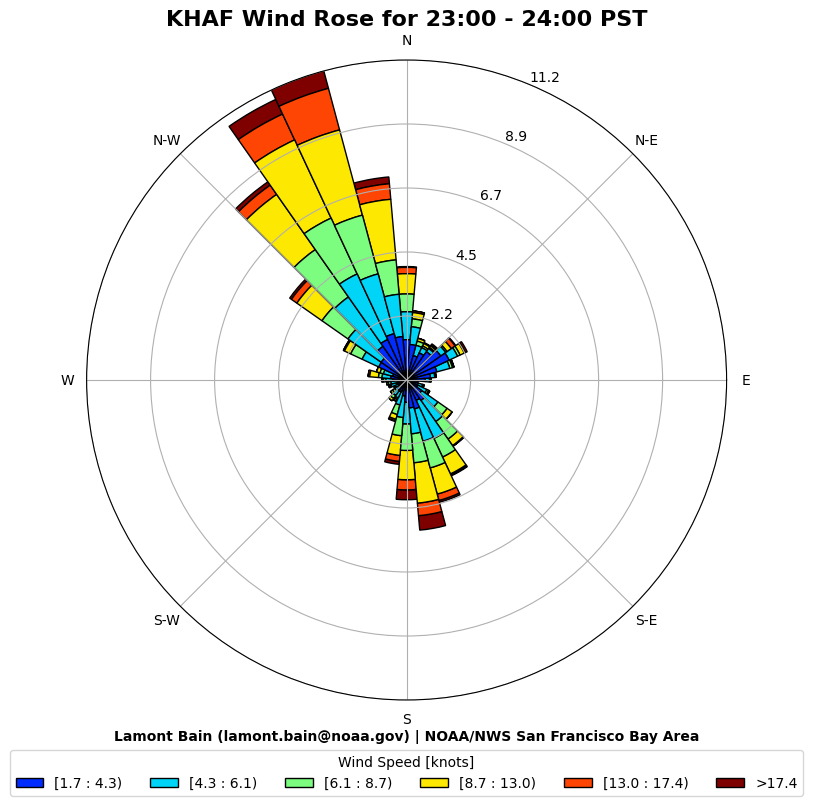

In [28]:
# @title Wind Rose By Time of Day
import pandas as pd
import pytz



# Create a timezone for Pacific Time (PST/PDT)
pst_zone = pytz.timezone('America/Los_Angeles')

# Convert UTC to PST/PDT directly without tz_localize
station_df['date_pst'] = station_df['date'].dt.tz_convert(pst_zone)

# Define wind speed categories and corresponding bins in knots (excluding Calm)
wind_categories = {
    '1': (1.738, 4.256),  # 2.0-4.9 mph
    '2': (4.348, 5.995),  # 5.0-6.9 mph
    '3': (6.086, 8.598),  # 7.0-9.9 mph
    '4': (8.689, 12.945),  # 10.0-14.9 mph
    '5': (13.037, 17.294),  # 15.0-19.9 mph
    '6': (17.386, np.inf)  # 20.0+ mph
}


color_list = [
    '#012cff',  # RGB (1, 44, 255)
    '#00d5f7',  # RGB (0, 213, 247)
    '#7cfd7f',  # RGB (124, 253, 127)
    '#fde801',  # RGB (253, 232, 1)
    '#ff4503',  # RGB (255, 69, 3)
    '#7e0100'   # RGB (126, 1, 0)
]

# Create the ListedColormap
cmap = ListedColormap(color_list)

# Create wind bins from the categories
wind_bins = np.array([min_speed for _, (min_speed, max_speed) in wind_categories.items()])

# Filter the DataFrame for rows where sus_wind is above the threshold (in knots)
filtered_df = station_df.query('sus_wind > 1.737').dropna(subset=['sus_wind', 'sus_wind_dir'])


'''
    1: "Moderate Rain",
    2: "Moderate Drizzle",
    3: "Moderate Snow",
    5: "Thunder",
    6: "Haze",
    7: "Smoke",
    8: "Dust",
    9: "Fog",
    13: "Light Rain",
    14: "Heavy Rain",
    17: "Light Drizzle",
    18: "Heavy Drizzle",
    28: "Light Thunder",
    29: "Heavy Thunder",
    31: "Mist",
    51: "Light Rain Shower",
    52: "Heavy Rain Shower"
'''


# Exclude specific weather codes
exclude_wxcodes = [1, 2, 3, 5, 13, 14, 28, 29, 51, 52]
filtered_df = filtered_df[~filtered_df['wxcode'].isin(exclude_wxcodes)]

filtered_df = filtered_df.dropna(subset=['sus_wind', 'sus_wind_dir'])



# Calculate the percentage of "Calm" winds (sus_wind <= 1.738 knots)
calm_percentage = (station_df['sus_wind'] <= 1.738).mean() * 100

# Generate wind rose plots for each hour of the day in PST
for hour in range(24):
    hourly_data = filtered_df[filtered_df['date_pst'].dt.hour == hour]

    if not hourly_data.empty:
        # Create the wind rose plot for the current hour
        plt.clf()
        fig = plt.figure(figsize=(8, 8))  # Set the overall plot size
        ax = WindroseAxes(fig, [0.1, 0.1, 0.8, 0.8])  # Adjust the size and position of the windrose
        fig.add_axes(ax)

        # Create the ListedColormap
        cmap = ListedColormap(color_list)

        # Plot wind rose with custom speed bins and the defined colormap
        ax.bar(hourly_data['sus_wind_dir'], hourly_data['sus_wind'],
               bins=wind_bins, normed=True, opening=1, edgecolor='black', nsector=36, cmap=cmap)

        # Add legend and labels
        plt.legend(title='Wind Speed [knots]', bbox_to_anchor=(0.5, -0.15), loc='lower center',
                   borderaxespad=0., ncol=6)
        ax.set_title(f"{site_id.upper()} Wind Rose for {hour}:00 - {hour + 1}:00 PST",
                     fontweight='bold', fontsize=16)
                #ALB Signature
        fig.text(0.5, 0.05, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

        # Show or save the figure
        #plt.tight_layout()
        plt.savefig(f'/content/drive/MyDrive/metar_archive/{site}/img/wind/hourly/{site}_wind_{hour}.png', bbox_inches='tight')
        #plt.show()  # You can save the figure instead with plt.savefig() if desired


In [29]:
# @title Establish Flight Categories
import pandas as pd

# Establish dataframes for various ceilings
lifr_cig = station_df[station_df['ceiling'] < 500].copy()
ifr_cig = station_df[(station_df['ceiling'] >= 500) & (station_df['ceiling'] < 1000)].copy()
# cat_e_cig = station_df[(station_df['ceiling'] >= 1000) & (station_df['ceiling'] <= 2000)].copy()
mvfr_cig = station_df[(station_df['ceiling'] >= 1000) & (station_df['ceiling'] <= 3100)].copy()
vfr_sky = station_df[(station_df['ceiling'] > 3100) | (station_df['ceiling'].isna())].copy()

# Establish dataframes for various visibilities
lifr_vis = station_df[station_df['visibility'] < 1].copy()
ifr_vis = station_df[(station_df['visibility'] >= 1) & (station_df['visibility'] < 3)].copy()
# cat_e_vis = station_df[(station_df['visibility'] >= 0) & (station_df['visibility'] < 3)].copy()
mvfr_vis = station_df[(station_df['visibility'] >= 3) & (station_df['visibility'] <= 5)].copy()
vfr_vis = station_df[station_df['visibility'] > 5].copy()

# Potential caveat—NaN ceiling probably means no ceiling observed, but may mean missing data
# Potential caveat—NaN visibility I think means no visibility observed




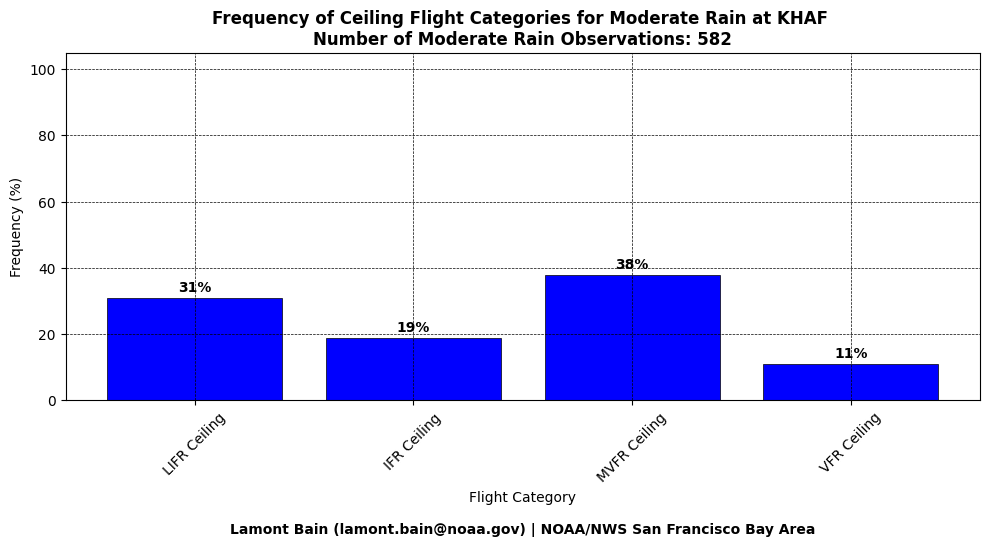

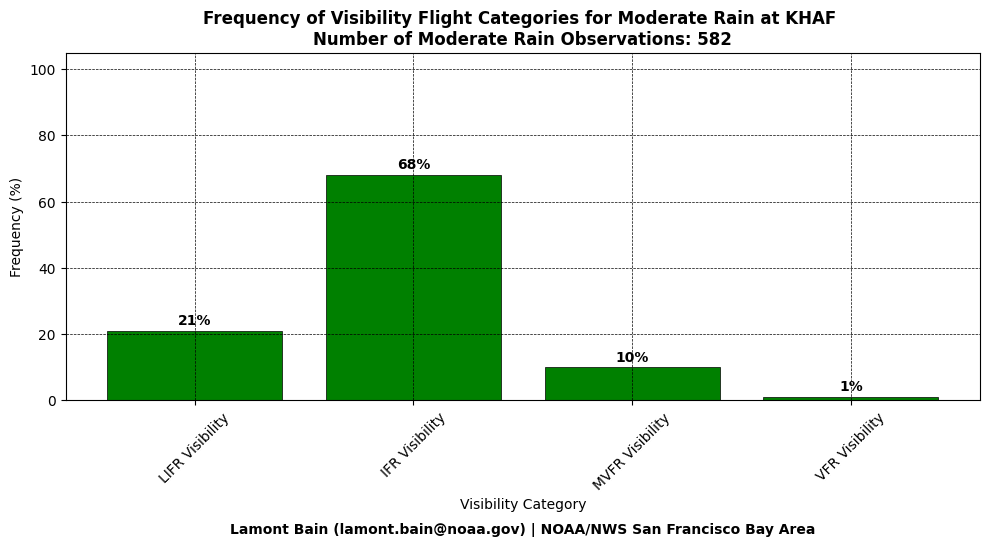

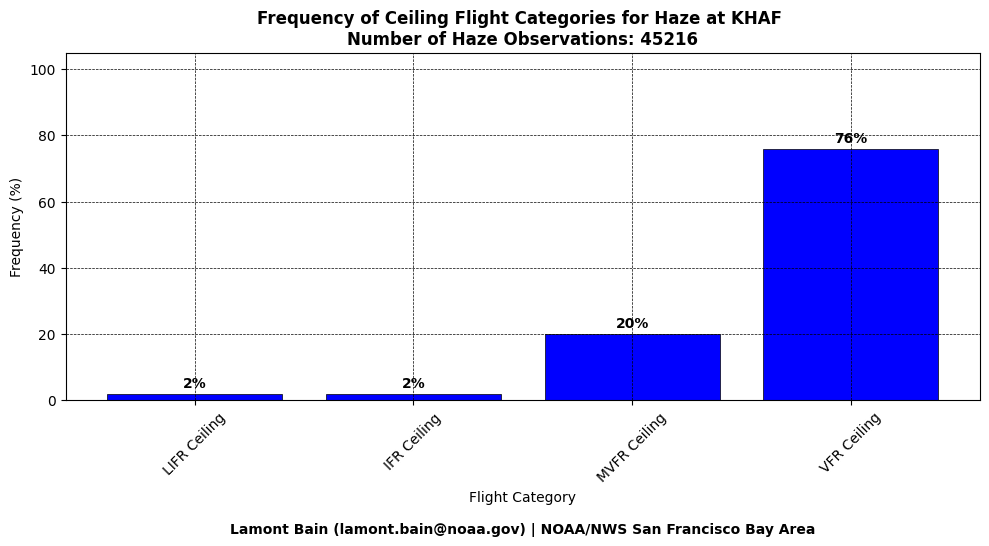

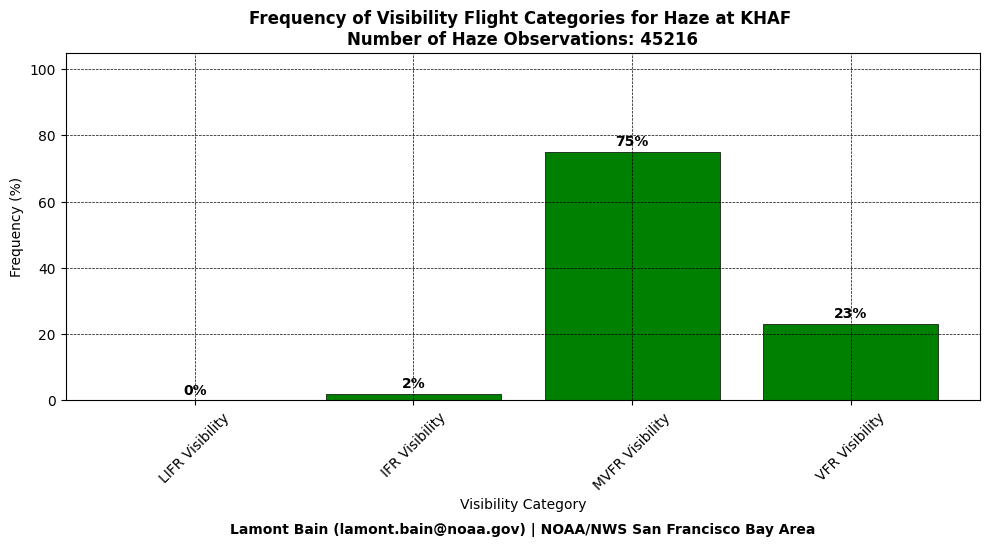

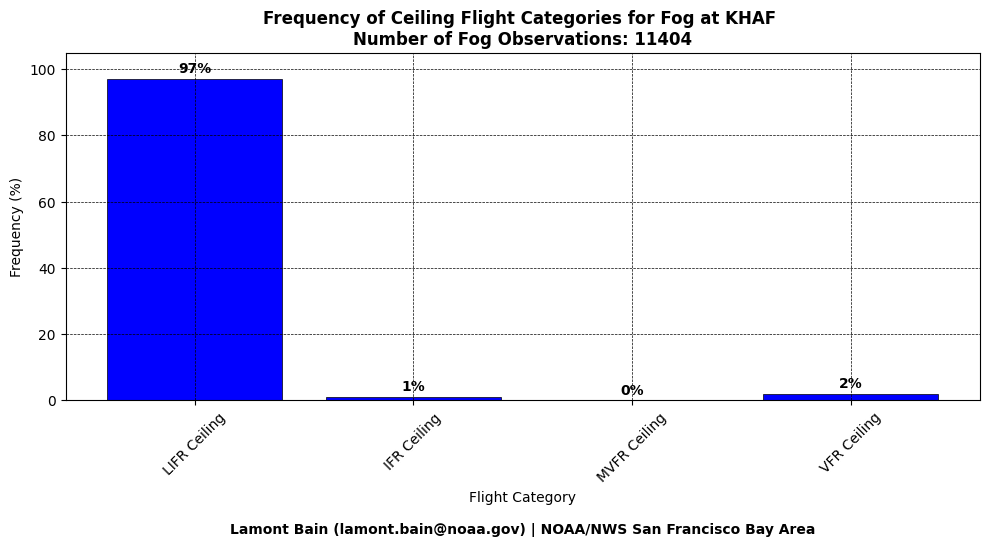

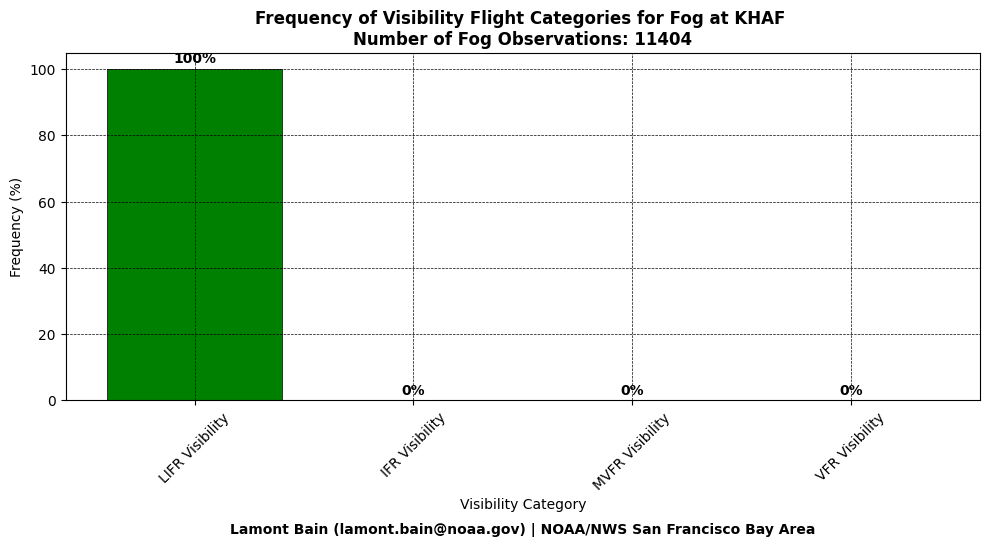

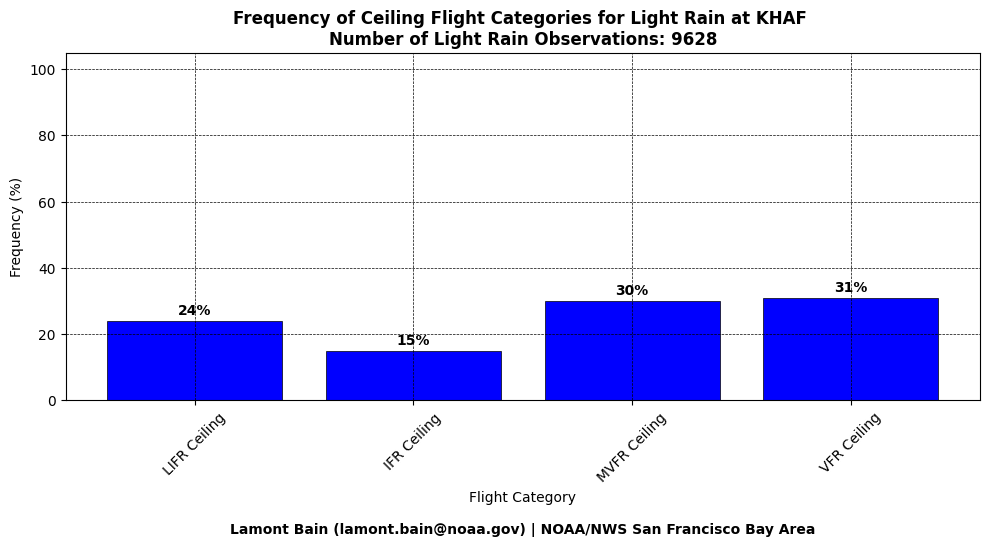

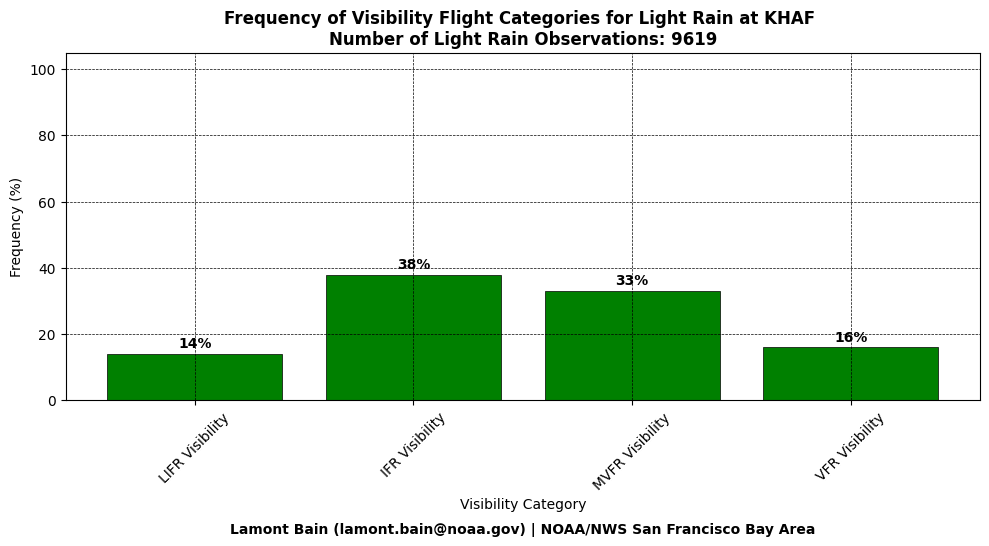

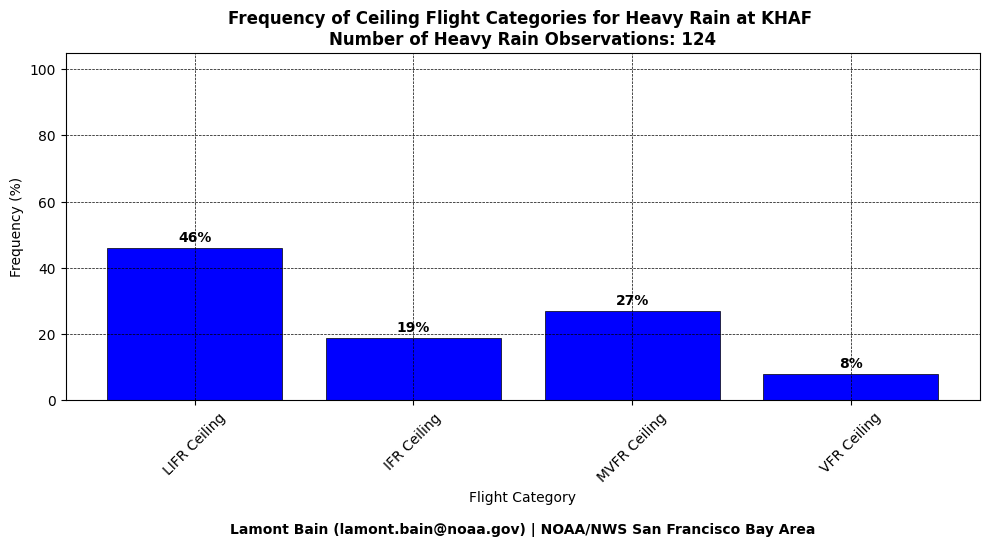

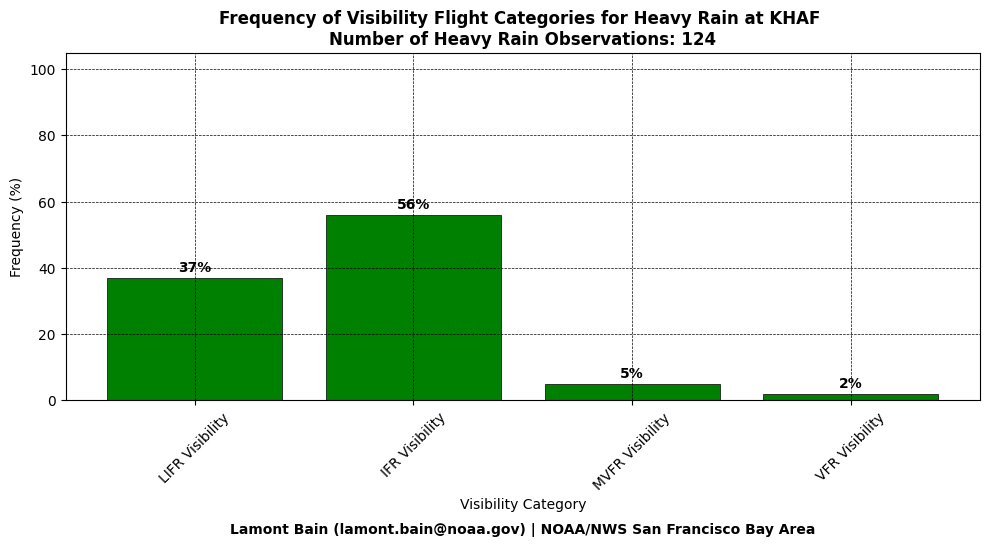

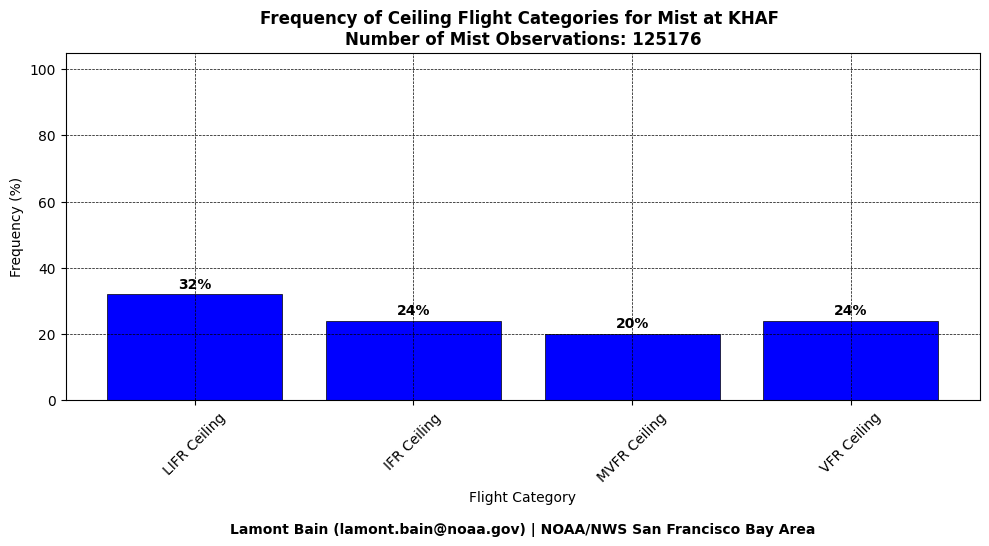

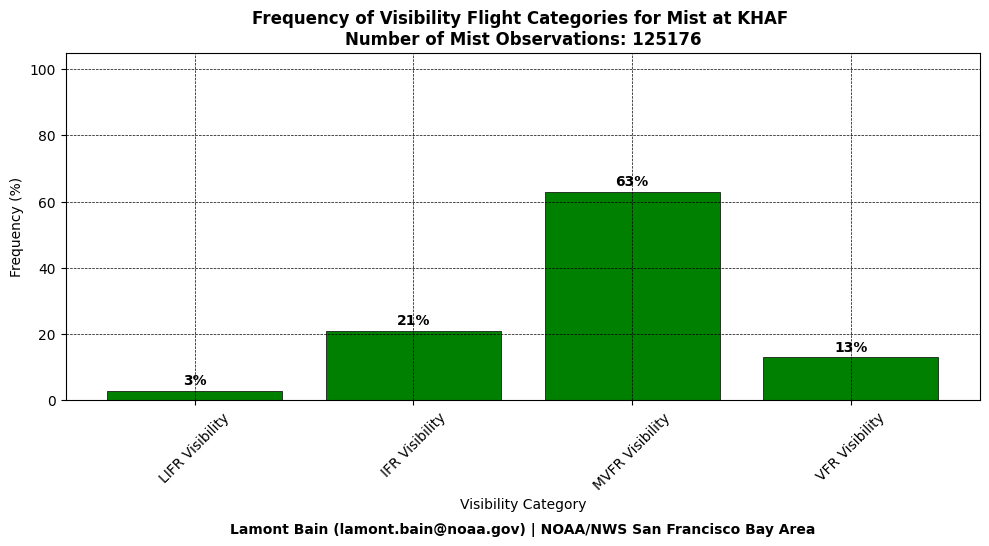

In [30]:
# @title Show Impact of Precipitation on Ceilings and Visibility

# Define wx codes with descriptions
wx_codes_dict = {
    0: "No Significant Weather",
    1: "Moderate Rain",
    2: "Moderate Drizzle",
    3: "Moderate Snow",
    5: "Thunder",
    6: "Haze",
    7: "Smoke",
    8: "Dust",
    9: "Fog",
    13: "Light Rain",
    14: "Heavy Rain",
    17: "Light Drizzle",
    18: "Heavy Drizzle",
    28: "Light Thunder",
    29: "Heavy Thunder",
    31: "Mist",
    51: "Light Rain Shower",
    52: "Heavy Rain Shower",
}

# Specify the wx codes you want to filter
specific_wx_codes = [1, 6, 9, 13, 14, 17, 18, 28, 29, 31, 51, 52]


#specific_wx_codes = [5, 6, 7, 9, 8, 28, 29, 31]

# Example of using the wx codes in your plots
for wx_code in specific_wx_codes:
    description = wx_codes_dict[wx_code]

    # Create the categories for ceilings
    categories = {
        'LIFR Ceiling': lifr_cig[lifr_cig['wxcode'] == wx_code],
        'IFR Ceiling': ifr_cig[ifr_cig['wxcode'] == wx_code],
        'MVFR Ceiling': mvfr_cig[mvfr_cig['wxcode'] == wx_code],
        'VFR Ceiling': vfr_sky[vfr_sky['wxcode'] == wx_code],
    }

    # Count occurrences for ceilings
    ceiling_counts = {key: len(value) for key, value in categories.items()}

    # Calculate total occurrences for frequency calculation
    total_ceiling_count = sum(ceiling_counts.values()) or 1  # Prevent division by zero

    # Calculate frequency as a percentage and round
    ceiling_frequencies = {key: round((count / total_ceiling_count) * 100) for key, count in ceiling_counts.items()}

    # Skip plotting if all frequencies are zero
    if sum(ceiling_frequencies.values()) == 0:
        continue

    # Plot Ceiling Categories
    plt.figure(figsize=(10, 6))
    bars = plt.bar(ceiling_frequencies.keys(), ceiling_frequencies.values(), color='blue', lw=0.5, edgecolor='black')
    plt.title(f'Frequency of Ceiling Flight Categories for {description} at {site.upper()} \nNumber of {description} Observations: {total_ceiling_count}', fontweight='bold')
    plt.xlabel('Flight Category')
    plt.ylabel('Frequency (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 105)  # Set y-axis limits
    plt.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
    plt.text(1.5, -40, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')
    plt.tight_layout()

    # Add percentage labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontweight='bold')

    save_path = f'/content/drive/MyDrive/metar_archive/{site}/img/wxtype/'
    save_filename = f'{save_path}{site}_ceiling_wx_type_{description.replace(" ", "")}.png'
    plt.savefig(save_filename)
    plt.show()

    # Create categories for visibility
    visibility_categories = {
        'LIFR Visibility': lifr_vis[lifr_vis['wxcode'] == wx_code],
        'IFR Visibility': ifr_vis[ifr_vis['wxcode'] == wx_code],
        'MVFR Visibility': mvfr_vis[mvfr_vis['wxcode'] == wx_code],
        'VFR Visibility': vfr_vis[vfr_vis['wxcode'] == wx_code],
    }

    # Count occurrences for visibility
    visibility_counts = {key: len(value) for key, value in visibility_categories.items()}

    # Calculate total occurrences for frequency calculation
    total_visibility_count = sum(visibility_counts.values()) or 1  # Prevent division by zero

    # Calculate frequency as a percentage and round
    visibility_frequencies = {key: round((count / total_visibility_count) * 100) for key, count in visibility_counts.items()}

    # Skip plotting if all frequencies are zero
    if sum(visibility_frequencies.values()) == 0:
        continue

    # Plot Visibility Categories
    plt.figure(figsize=(10, 6))
    bars = plt.bar(visibility_frequencies.keys(), visibility_frequencies.values(), color='green', lw=0.5, edgecolor='black')
    plt.title(f'Frequency of Visibility Flight Categories for {description} at {site.upper()} \nNumber of {description} Observations: {total_visibility_count}', fontweight='bold')
    plt.xlabel('Visibility Category')
    plt.ylabel('Frequency (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 105)  # Set y-axis limits
    plt.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
    plt.text(1.5, -40, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')
    plt.tight_layout()


    # Add percentage labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontweight='bold')

    save_filename = f'{save_path}{site}_vis_wx_type_{description.replace(" ", "")}.png'
    plt.savefig(save_filename)
    plt.show()


In [31]:
# @title Create Ceiling and Visibility Events (New Methodology)
import pandas as pd

# Function to create weather events based on criteria (for ceiling or visibility)
def make_wx_event(df, time_thresh_minutes, min_thresh, max_thresh, exclude_wxcodes, event_type):
    """
    Function to group ceiling or visibility events based on thresholds and weather codes.

    Parameters:
    - df: DataFrame containing ceiling or visibility data.
    - time_thresh_minutes: Minimum duration for grouping events (in minutes).
    - min_thresh: Minimum threshold for events.
    - max_thresh: Maximum threshold for events.
    - exclude_wxcodes: List of weather codes to exclude from events.
    - event_type: 'ceiling' or 'visibility' to determine which data to filter.

    Returns:
    - DataFrame with grouped events.
    """
    # Ensure date is a datetime object
    df.loc[:, 'date'] = pd.to_datetime(df['date'])

    # Filter based on the event type (ceiling or visibility)
    if event_type == 'ceiling':
        df_filtered = df[(df['ceiling'] >= min_thresh) & (df['ceiling'] <= max_thresh)].copy()
    else:  # event_type == 'visibility'
        df_filtered = df[(df['visibility'] >= min_thresh) & (df['visibility'] <= max_thresh)].copy()

    # Exclude specific weather codes
    df_filtered = df_filtered[~df_filtered['wxcode'].isin(exclude_wxcodes)]

    # Group events based on time threshold
    df_filtered.loc[:, 'time_diff'] = df_filtered['date'].diff().dt.total_seconds() / 60
    df_filtered.loc[:, 'group_number'] = (df_filtered['time_diff'] > time_thresh_minutes).cumsum()

    # Calculate the minimum threshold and duration of each event
    if event_type == 'ceiling':
        grouped_events = df_filtered.groupby('group_number').agg({
            'date': ['min', 'max'],
            'ceiling': 'min',
            'dewpt_dep': 'mean',
            'visibility': 'mean',
            'sus_wind': 'mean'
        }).reset_index()
        # Flatten MultiIndex columns
        grouped_events.columns = ['group_number', 'start_time', 'end_time', 'min_ceiling', 'mean_dewpt_dep', 'mean_visibility', 'mean_wind']

    else:  # event_type == 'visibility'
        grouped_events = df_filtered.groupby('group_number').agg({
            'date': ['min', 'max'],
            'ceiling': 'min',
            'dewpt_dep': 'mean',
            'visibility': 'mean',
            'sus_wind': 'mean'
        }).reset_index()
        # Flatten MultiIndex columns
        grouped_events.columns = ['group_number', 'start_time', 'end_time', 'min_ceiling', 'mean_dewpt_dep', 'mean_visibility', 'mean_wind']

    # Calculate event duration
    grouped_events['event_duration'] = grouped_events['end_time'] - grouped_events['start_time']

    return grouped_events

def filter_events_by_duration(df, min_duration_minutes):
    """
    Filters grouped events by a minimum duration.

    Parameters:
    - df: DataFrame containing grouped events.
    - min_duration_minutes: Minimum duration for an event to be included (in minutes).

    Returns:
    - DataFrame with filtered events.
    """
    if df is not None:
        df = df.copy()
        df['event_duration'] = pd.to_timedelta(df['event_duration'])
        min_duration = pd.Timedelta(minutes=min_duration_minutes)
        df = df[df['event_duration'] >= min_duration]
        df['event_duration_minutes'] = df['event_duration'].dt.total_seconds() / 60
        print(f"You now have {len(df)} events exceeding {min_duration_minutes} minutes.")
    else:
        print("Error: df is None")

    return df

# Function to create events for ceiling and visibility separately
def create_events_for_criteria(station_df, time_thresh_minutes, exclude_wxcodes, min_duration_minutes, criteria, event_type):
    """
    Create events for each flight category separately for ceilings and visibility.

    Parameters:
    - station_df: DataFrame containing ceiling and visibility data.
    - time_thresh_minutes: Minimum duration for grouping events (in minutes).
    - exclude_wxcodes: List of weather codes to exclude from events.
    - min_duration_minutes: Minimum duration for an event to be included (in minutes).
    - criteria: Dictionary of thresholds (either for ceiling or visibility).
    - event_type: 'ceiling' or 'visibility' to determine which data to filter.

    Returns:
    - Dictionary of DataFrames with events for each flight category.
    """
    criteria_dfs = {}

    for category, thresholds in criteria.items():
        min_thresh = thresholds["min"]
        max_thresh = thresholds["max"]

        print(f"Processing category: {category} ({min_thresh} - {max_thresh})")

        # Create events based on the current thresholds
        df_grouped = make_wx_event(station_df, time_thresh_minutes, min_thresh, max_thresh, exclude_wxcodes, event_type)

        if df_grouped is not None:
            df_grouped.reset_index(drop=True, inplace=True)
            filtered_events = filter_events_by_duration(df_grouped, min_duration_minutes)
            criteria_dfs[category] = filtered_events
        else:
            print(f"No events found for category {category}")
            criteria_dfs[category] = pd.DataFrame()  # Empty DataFrame for categories with no events

    return criteria_dfs

# Flight categories for ceiling
ceiling_categories = {
    "LIFR": {"min": 0, "max": 499},
    "IFR": {"min": 500, "max": 999},
    "MVFR": {"min": 1000, "max": 3000},
    "CAT_E": {"min": 0, "max": 2000},
    "VFR": {"min": 3001, "max": float('inf')}
}

# Flight categories for visibility
visibility_categories = {
    "LIFR": {"min": 0, "max": 1},          # LifR: Visibility less than 1 mile
    "IFR": {"min": 1, "max": 3},          # IFR: Visibility 1 to 3 miles
    "MVFR": {"min": 3, "max": 5},         # MVFR: Visibility 3 to 5 miles
    "CAT_E": {"min": 0, "max": 3},        # CAT_E: Visibility 0 to 2 miles
    "VFR": {"min": 5.1, "max": float('inf')} # VFR: Visibility greater than 5 miles
}

# Parameters
time_thresh_minutes = 120
exclude_wxcodes = [1, 3, 13, 14, 28, 29, 51, 52]


'''
    1: "Moderate Rain",
    2: "Moderate Drizzle",
    3: "Moderate Snow",
    5: "Thunder",
    6: "Haze",
    7: "Smoke",
    8: "Dust",
    9: "Fog",
    13: "Light Rain",
    14: "Heavy Rain",
    17: "Light Drizzle",
    18: "Heavy Drizzle",
    28: "Light Thunder",
    29: "Heavy Thunder",
    31: "Mist",
    51: "Light Rain Shower",
    52: "Heavy Rain Shower"
'''




min_duration_minutes = 60

# Create separate DataFrames for ceiling events
cig_event_dfs = create_events_for_criteria(station_df, time_thresh_minutes, exclude_wxcodes, min_duration_minutes, ceiling_categories, event_type='ceiling')

# Create separate DataFrames for visibility events
vis_event_dfs = create_events_for_criteria(station_df, time_thresh_minutes, exclude_wxcodes, min_duration_minutes, visibility_categories, event_type='visibility')

# Now, you can access each category's events via the dictionaries 'ceiling_event_dfs' and 'visibility_event_dfs'
# Example: To get the IFR ceiling events, use cig_event_dfs['IFR']
# Example: To get the IFR visibility events, use vis_event_dfs['IFR']

cig_event_dfs['IFR'].head()

Processing category: LIFR (0 - 499)
You now have 2606 events exceeding 60 minutes.
Processing category: IFR (500 - 999)
You now have 2910 events exceeding 60 minutes.
Processing category: MVFR (1000 - 3000)
You now have 3580 events exceeding 60 minutes.
Processing category: CAT_E (0 - 2000)
You now have 3796 events exceeding 60 minutes.
Processing category: VFR (3001 - inf)
You now have 1658 events exceeding 60 minutes.
Processing category: LIFR (0 - 1)
You now have 1271 events exceeding 60 minutes.
Processing category: IFR (1 - 3)
You now have 3552 events exceeding 60 minutes.
Processing category: MVFR (3 - 5)
You now have 4984 events exceeding 60 minutes.
Processing category: CAT_E (0 - 3)
You now have 3403 events exceeding 60 minutes.
Processing category: VFR (5.1 - inf)
You now have 3983 events exceeding 60 minutes.


,group_number,start_time,end_time,min_ceiling,mean_dewpt_dep,mean_visibility,mean_wind,event_duration,event_duration_minutes
0,0,2010-01-26 05:55:00+00:00,2010-01-26 07:35:00+00:00,700.0,0.0,3.000000,16.501667,0 days 01:40:00,100.0
2,2,2010-01-27 22:55:00+00:00,2010-01-28 10:15:00+00:00,500.0,0.0,8.935484,4.033226,0 days 11:20:00,680.0
3,3,2010-01-30 00:55:00+00:00,2010-01-30 03:15:00+00:00,500.0,0.0,1.166667,11.333333,0 days 02:20:00,140.0
4,4,2010-02-03 00:55:00+00:00,2010-02-03 02:35:00+00:00,800.0,0.0,7.333333,1.333333,0 days 01:40:00,100.0
7,7,2010-02-05 10:55:00+00:00,2010-02-05 13:15:00+00:00,500.0,0.0,1.666667,0.000000,0 days 02:20:00,140.0


In [32]:
# @title Ceiling and Visibility Events Duration (by hour)



import pandas as pd
import matplotlib.pyplot as plt

start_year = station_df['date'].dt.year.min()
end_year = station_df['date'].dt.year.max()

# Function to prepare average event durations in hours from event DataFrames
def prepare_monthly_avg_durations_in_hours(event_dfs):
    """ Prepare monthly average durations in hours from event DataFrames. """
    monthly_avg_durations = {i: [] for i in range(1, 13)}  # Initialize a list for each month

    for category, df in event_dfs.items():
        avg_durations = [0] * 12

        if not df.empty:  # Check to make sure that the dataframe isn't empty
            df['month'] = df['start_time'].dt.month  # Extract month from start_time
            # Calculate the average duration per month (convert minutes to hours)
            monthly_avg_duration = df.groupby('month')['event_duration_minutes'].mean() / 60

            for month, avg_duration in monthly_avg_duration.items():
                avg_durations[month - 1] = avg_duration  # month - 1 for zero-based index

        monthly_avg_durations[category] = avg_durations

    return pd.DataFrame(monthly_avg_durations, index=range(1, 13), columns=event_dfs.keys()).fillna(0)

# Prepare average durations in hours for ceiling and visibility events
ceiling_avg_durations_in_hours = prepare_monthly_avg_durations_in_hours(cig_event_dfs)
visibility_avg_durations_in_hours = prepare_monthly_avg_durations_in_hours(vis_event_dfs)

# Create bar plots for average durations in hours
#plt.clf()
#fig, ax = plt.subplots(2, 1, figsize=(25, 10))

# Bar plot for average ceiling event durations in hours
#ceiling_bars = ceiling_avg_durations_in_hours.plot(kind='bar', ax=ax[0], lw=1.0, edgecolor='black',
#                                                   color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False, width=0.8)
#ax[0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
#ax[0].set_title(f'Monthly Average Duration of Ceiling Events at {site.upper()} | Period of Record: {start_year} to {end_year}', fontweight='bold', fontsize=18)
#ax[0].set_xlabel('Month', fontweight='bold')
#ax[0].set_ylabel('Avg Duration (hours)', fontweight='bold')
#ax[0].set_ylim(0, ceiling_avg_durations_in_hours.max().max() + 1)  # Adjust y-axis to fit data
#ax[0].set_xticks(range(12))
#ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0, fontsize=15)

# Bar plot for average visibility event durations in hours
#visibility_bars = visibility_avg_durations_in_hours.plot(kind='bar', ax=ax[1], lw=1.0, edgecolor='black',
#                                                         color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
#ax[1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
#ax[1].set_title(f'Monthly Average Duration of Visibility Events at {site.upper()} | Period of Record: {start_year} to {end_year}', fontweight='bold', fontsize=18)
#ax[1].set_xlabel('Month', fontweight='bold')
#ax[1].set_ylabel('Avg Duration (hours)', fontweight='bold')
#ax[1].set_ylim(0, visibility_avg_durations_in_hours.max().max() + 1)  # Adjust y-axis to fit data
#ax[1].set_xticks(range(12))
#ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0, fontsize=15)

# Create a single horizontal legend below the bottom subplot
#handles, labels = visibility_bars.get_legend_handles_labels()  # Get handles from the last plot
#fig.legend(handles, labels, title='Flight Categories', bbox_to_anchor=(0.50, -0.03), loc='center', ncol=len(labels))
#fig.text(0.50, -0.07, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

# Show the plots
#plt.tight_layout()
#plt.show()

#cig_event_dfs['IFR']['event_duration_minutes'].sort_values(ascending=False)
#cig_event_dfs['IFR'].sort_values(by='event_duration_minutes', ascending=False)


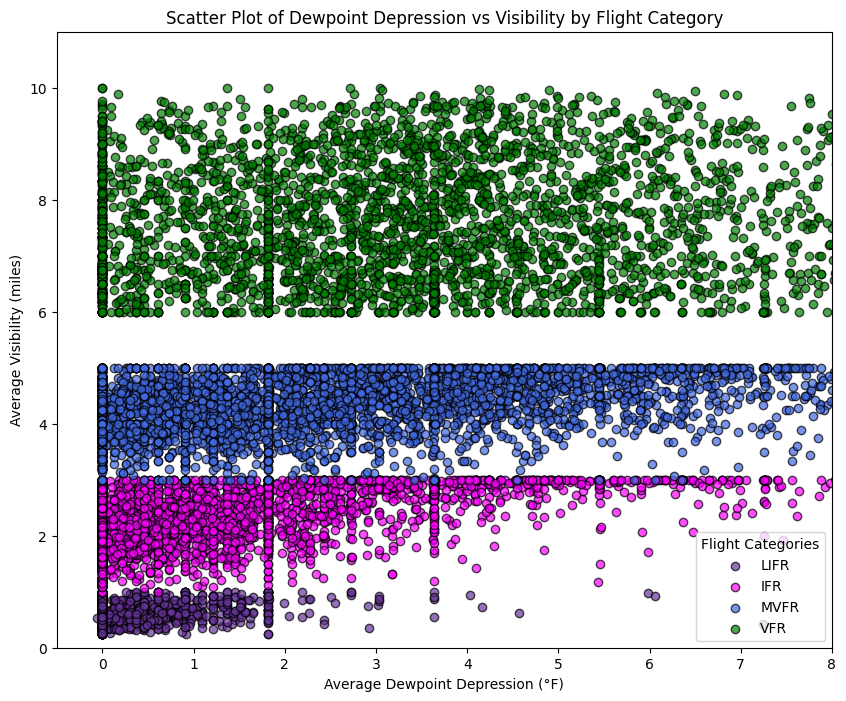

In [33]:
# @title Visibility Category vs Dewpoint Depression
import matplotlib.pyplot as plt

# Data for each category
categories = {
    "LIFR": vis_event_dfs['LIFR'],
    "IFR": vis_event_dfs['IFR'],
    "MVFR": vis_event_dfs['MVFR'],
    "VFR": vis_event_dfs['VFR']
}

# Define colors for each category
colors = {
    "LIFR": 'rebeccapurple',
    "IFR": 'magenta',
    "MVFR": 'royalblue',
    "VFR": 'green'
}

# Create a scatter plot for each category
plt.figure(figsize=(10, 8))

for category, data in categories.items():
    plt.scatter(data['mean_dewpt_dep'], data['mean_visibility'],
                alpha=0.7, edgecolor='k',
                label=category, color=colors[category])

# Add labels and title
plt.xlabel('Average Dewpoint Depression (°F)')
plt.ylabel('Average Visibility (miles)')
plt.title('Scatter Plot of Dewpoint Depression vs Visibility by Flight Category')

# Set limits for the axes
plt.xlim(-0.5, 8)
plt.ylim(0, 11)

# Add legend
plt.legend(title='Flight Categories')

# Show the plot
plt.show()


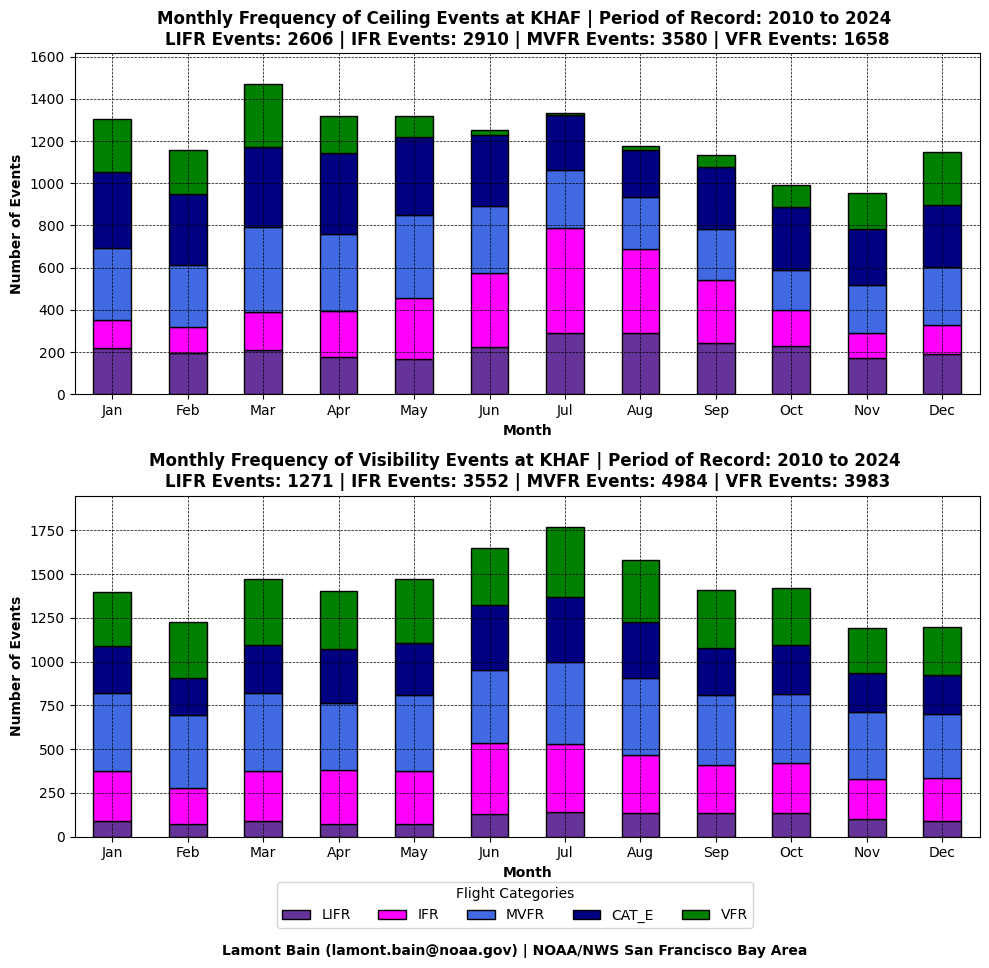

In [34]:
# @title Generate Stacked Bar Plot of Ceiling and Visibility Events through the Year
import pandas as pd
import matplotlib.pyplot as plt

start_year = station_df['date'].dt.year.min()
end_year = station_df['date'].dt.year.max()

# Function to prepare monthly counts from event DataFrames
def prepare_monthly_counts(event_dfs):
    """ Prepare monthly counts from event DataFrames. """
    monthly_counts = {i: [] for i in range(1, 13)}  # Initialize a list for each month

    for category, df in event_dfs.items():
        counts = [0] * 12

        if not df.empty:  # Check to make sure that the dataframe isn't empty
            df['month'] = df['start_time'].dt.month  # Extract month from start_time
            monthly_count = df['month'].value_counts().sort_index()  # Count events per month

            for month, count in monthly_count.items():
                counts[month - 1] = count  # month - 1 for zero-based index

        monthly_counts[category] = counts

    return pd.DataFrame(monthly_counts, index=range(1, 13), columns=event_dfs.keys()).fillna(0)

# Prepare monthly counts for ceiling and visibility events
ceiling_monthly_counts = prepare_monthly_counts(cig_event_dfs)
visibility_monthly_counts = prepare_monthly_counts(vis_event_dfs)

# Create stacked bar plots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Create Counts of Various Items
lifr_cig_counts = len(cig_event_dfs['LIFR'])
ifr_cig_counts = len(cig_event_dfs['IFR'])
cat_e_cig_counts = len(cig_event_dfs['CAT_E'])
mvfr_cig_counts = len(cig_event_dfs['MVFR'])
vfr_sky_counts = len(cig_event_dfs['VFR'])

lifr_vis_counts = len(vis_event_dfs['LIFR'])
ifr_vis_counts = len(vis_event_dfs['IFR'])
cat_e_vis_counts = len(vis_event_dfs['CAT_E'])
mvfr_vis_counts = len(vis_event_dfs['MVFR'])
vfr_vis_counts = len(vis_event_dfs['VFR'])

# Dynamically calculate the max y-limits with a 10% buffer
max_ceiling_events = ceiling_monthly_counts.sum(axis=1).max()
max_visibility_events = visibility_monthly_counts.sum(axis=1).max()

# Adding a 10% buffer to the maximum y-axis value
ceiling_ylim = max_ceiling_events * 1.1
visibility_ylim = max_visibility_events * 1.1

# Stacked bar plot for ceiling events
ceiling_bars = ceiling_monthly_counts.plot(kind='bar', stacked=True, ax=ax[0], lw=1.0, edgecolor='black',
                                           color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[0].set_title(f'Monthly Frequency of Ceiling Events at {site.upper()} | Period of Record: {start_year} to {end_year} \nLIFR Events: {lifr_cig_counts} | IFR Events: {ifr_cig_counts} | MVFR Events: {mvfr_cig_counts} | VFR Events: {vfr_sky_counts}', fontweight='bold')
ax[0].set_xlabel('Month', fontweight='bold')
ax[0].set_ylabel('Number of Events', fontweight='bold')
ax[0].set_ylim(0, ceiling_ylim)  # Set dynamic ylim for ceiling events
ax[0].set_xticks(range(12))
ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

# Stacked bar plot for visibility events
visibility_bars = visibility_monthly_counts.plot(kind='bar', stacked=True, ax=ax[1], lw=1.0, edgecolor='black',
                                                 color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[1].set_title(f'Monthly Frequency of Visibility Events at {site.upper()} | Period of Record: {start_year} to {end_year} \nLIFR Events: {lifr_vis_counts} | IFR Events: {ifr_vis_counts} | MVFR Events: {mvfr_vis_counts} | VFR Events: {vfr_vis_counts}', fontweight='bold')
ax[1].set_xlabel('Month', fontweight='bold')
ax[1].set_ylabel('Number of Events', fontweight='bold')
ax[1].set_ylim(0, visibility_ylim)  # Set dynamic ylim for visibility events
ax[1].set_xticks(range(12))
ax[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)

plt.tight_layout()

# Create a single horizontal legend below the bottom subplot
handles, labels = visibility_bars.get_legend_handles_labels()  # Get handles from the last plot
fig.legend(handles, labels, title='Flight Categories', bbox_to_anchor=(0.52, 0.09), loc='center', ncol=len(labels))
fig.text(0.52, 0.04, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')


plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
save_path = f'/content/drive/MyDrive/metar_archive/{site}/img/ceiling-visibility/'
save_filename = f'{save_path}{site}_monthly_frequency.png'
plt.savefig(save_filename)

plt.show()


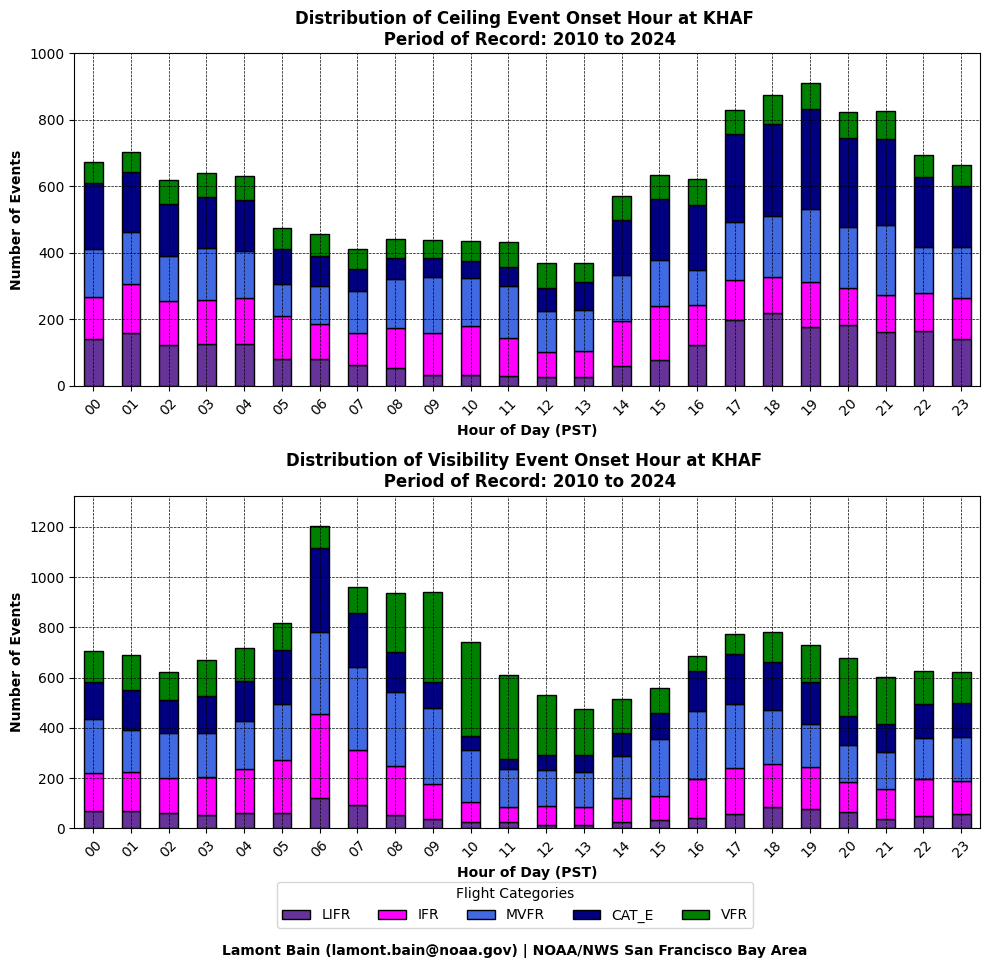

In [35]:
# @title Generate Stacked Bar Plot of the Onset of Ceiling and Visibility Events by Hour

import pandas as pd
import matplotlib.pyplot as plt

start_year = station_df['date'].dt.year.min()
end_year = station_df['date'].dt.year.max()

# Function to prepare hourly counts from event DataFrames
def prepare_hourly_counts(event_dfs):
    """ Prepare hourly counts from event DataFrames. """
    hourly_counts = {i: [] for i in range(24)}  # Initialize a list for each hour of the day

    for category, df in event_dfs.items():
        counts = [0] * 24

        if not df.empty:  # Check to make sure that the dataframe isn't empty
            df['hour'] = df['start_time'].dt.tz_convert('America/Los_Angeles').dt.hour  # Convert to PST and extract hour
            hourly_count = df['hour'].value_counts().sort_index()  # Count events per hour

            for hour, count in hourly_count.items():
                counts[hour] = count  # Use hour as zero-based index

        hourly_counts[category] = counts

    return pd.DataFrame(hourly_counts, index=range(24), columns=event_dfs.keys()).fillna(0)

# Prepare hourly counts for ceiling and visibility events
ceiling_hourly_counts = prepare_hourly_counts(cig_event_dfs)
visibility_hourly_counts = prepare_hourly_counts(vis_event_dfs)

# Calculate dynamic y-limits based on the maximum count for each event
max_ceiling_events = ceiling_hourly_counts.sum(axis=1).max()
max_visibility_events = visibility_hourly_counts.sum(axis=1).max()

# Create stacked bar plots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Stacked bar plot for ceiling events
ceiling_bars = ceiling_hourly_counts.plot(kind='bar', stacked=True, ax=ax[0], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[0].set_title(f'Distribution of Ceiling Event Onset Hour at {site.upper()} \n Period of Record: {start_year} to {end_year}', fontweight='bold')
ax[0].set_xlabel('Hour of Day (PST)', fontweight='bold')
ax[0].set_ylabel('Number of Events', fontweight='bold')
ax[0].set_ylim(0, max_ceiling_events * 1.1)  # Dynamically set y-limit slightly above the max value
ax[0].set_xticks(range(24))
ax[0].set_xticklabels([f'{hour:02}' for hour in range(24)], rotation=45)  # Rotate x-ticks

# Stacked bar plot for visibility events
visibility_bars = visibility_hourly_counts.plot(kind='bar', stacked=True, ax=ax[1], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[1].set_title(f'Distribution of Visibility Event Onset Hour at {site.upper()} \n Period of Record: {start_year} to {end_year}', fontweight='bold')
ax[1].set_xlabel('Hour of Day (PST)', fontweight='bold')
ax[1].set_ylabel('Number of Events', fontweight='bold')
ax[1].set_ylim(0, max_visibility_events * 1.1)  # Dynamically set y-limit slightly above the max value
ax[1].set_xticks(range(24))
ax[1].set_xticklabels([f'{hour:02}' for hour in range(24)], rotation=45)  # Rotate x-ticks



# Create a single horizontal legend below the bottom subplot
handles, labels = visibility_bars.get_legend_handles_labels()  # Get handles from the last plot
fig.legend(handles, labels, title='Flight Categories', bbox_to_anchor=(0.52, 0.09), loc='center', ncol=len(labels))
fig.text(0.52, 0.04, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
save_path = f'/content/drive/MyDrive/metar_archive/{site}/img/ceiling-visibility/'
save_filename = f'{save_path}{site}_onset_frequency.png'
plt.savefig(save_filename)
plt.show()


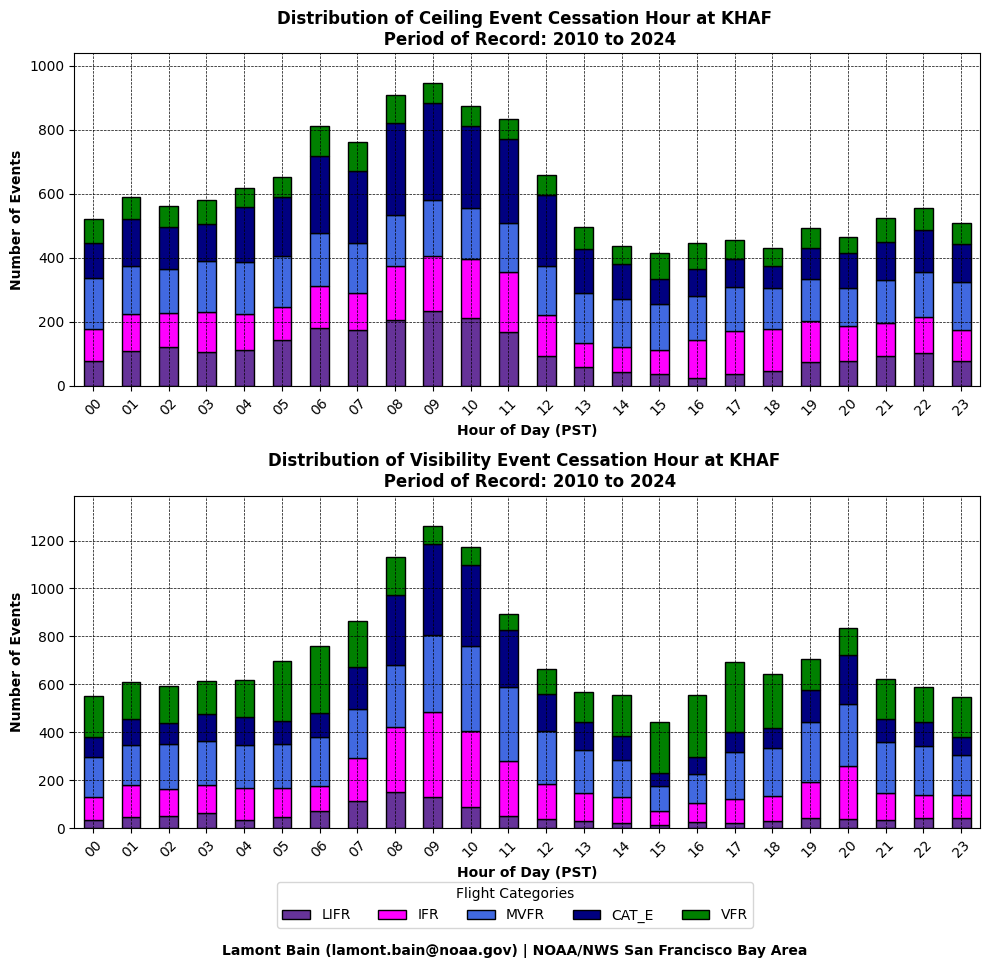

In [36]:
# @title Generate Stacked Bar Plot of the Cessation of Ceiling and Visibility Events by Hour

# Function to prepare hourly counts from event DataFrames
def prepare_hourly_counts(event_dfs):
    """ Prepare hourly counts from event DataFrames. """
    hourly_counts = {i: [] for i in range(24)}  # Initialize a list for each hour of the day

    for category, df in event_dfs.items():
        counts = [0] * 24

        if not df.empty:  # Check to make sure that the dataframe isn't empty
            df['hour'] = df['end_time'].dt.tz_convert('America/Los_Angeles').dt.hour  # Convert to PST and extract hour
            hourly_count = df['hour'].value_counts().sort_index()  # Count events per hour

            for hour, count in hourly_count.items():
                counts[hour] = count  # Use hour as zero-based index

        hourly_counts[category] = counts

    return pd.DataFrame(hourly_counts, index=range(24), columns=event_dfs.keys()).fillna(0)

# Prepare hourly counts for ceiling and visibility events
ceiling_hourly_counts = prepare_hourly_counts(cig_event_dfs)
visibility_hourly_counts = prepare_hourly_counts(vis_event_dfs)

# Determine dynamic y-limits based on data
max_ceiling = ceiling_hourly_counts.sum(axis=1).max() * 1.1  # Adding 10% buffer to the max value
max_visibility = visibility_hourly_counts.sum(axis=1).max() * 1.1  # Adding 10% buffer to the max value

# Create stacked bar plots
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Stacked bar plot for ceiling events
ceiling_bars = ceiling_hourly_counts.plot(kind='bar', stacked=True, ax=ax[0], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[0].set_title(f'Distribution of Ceiling Event Cessation Hour at {site.upper()} \n Period of Record: {start_year} to {end_year}', fontweight='bold')
ax[0].set_xlabel('Hour of Day (PST)', fontweight='bold')
ax[0].set_ylabel('Number of Events', fontweight='bold')
ax[0].set_ylim(0, max_ceiling)  # Set dynamic y-limits
ax[0].set_xticks(range(24))
ax[0].set_xticklabels([f'{hour:02}' for hour in range(24)], rotation=45)  # Rotate x-ticks

# Stacked bar plot for visibility events
visibility_bars = visibility_hourly_counts.plot(kind='bar', stacked=True, ax=ax[1], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[1].set_title(f'Distribution of Visibility Event Cessation Hour at {site.upper()} \n Period of Record: {start_year} to {end_year}', fontweight='bold')
ax[1].set_xlabel('Hour of Day (PST)', fontweight='bold')
ax[1].set_ylabel('Number of Events', fontweight='bold')
ax[1].set_ylim(0, max_visibility)  # Set dynamic y-limits
ax[1].set_xticks(range(24))
ax[1].set_xticklabels([f'{hour:02}' for hour in range(24)], rotation=45)  # Rotate x-ticks


# Create a single horizontal legend below the bottom subplot
handles, labels = visibility_bars.get_legend_handles_labels()  # Get handles from the last plot
fig.legend(handles, labels, title='Flight Categories', bbox_to_anchor=(0.52, 0.09), loc='center', ncol=len(labels))
fig.text(0.52, 0.04, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
save_path = f'/content/drive/MyDrive/metar_archive/{site}/img/ceiling-visibility/'
save_filename = f'{save_path}{site}_ending_frequency.png'
plt.savefig(save_filename)
plt.show()


<Figure size 640x480 with 0 Axes>

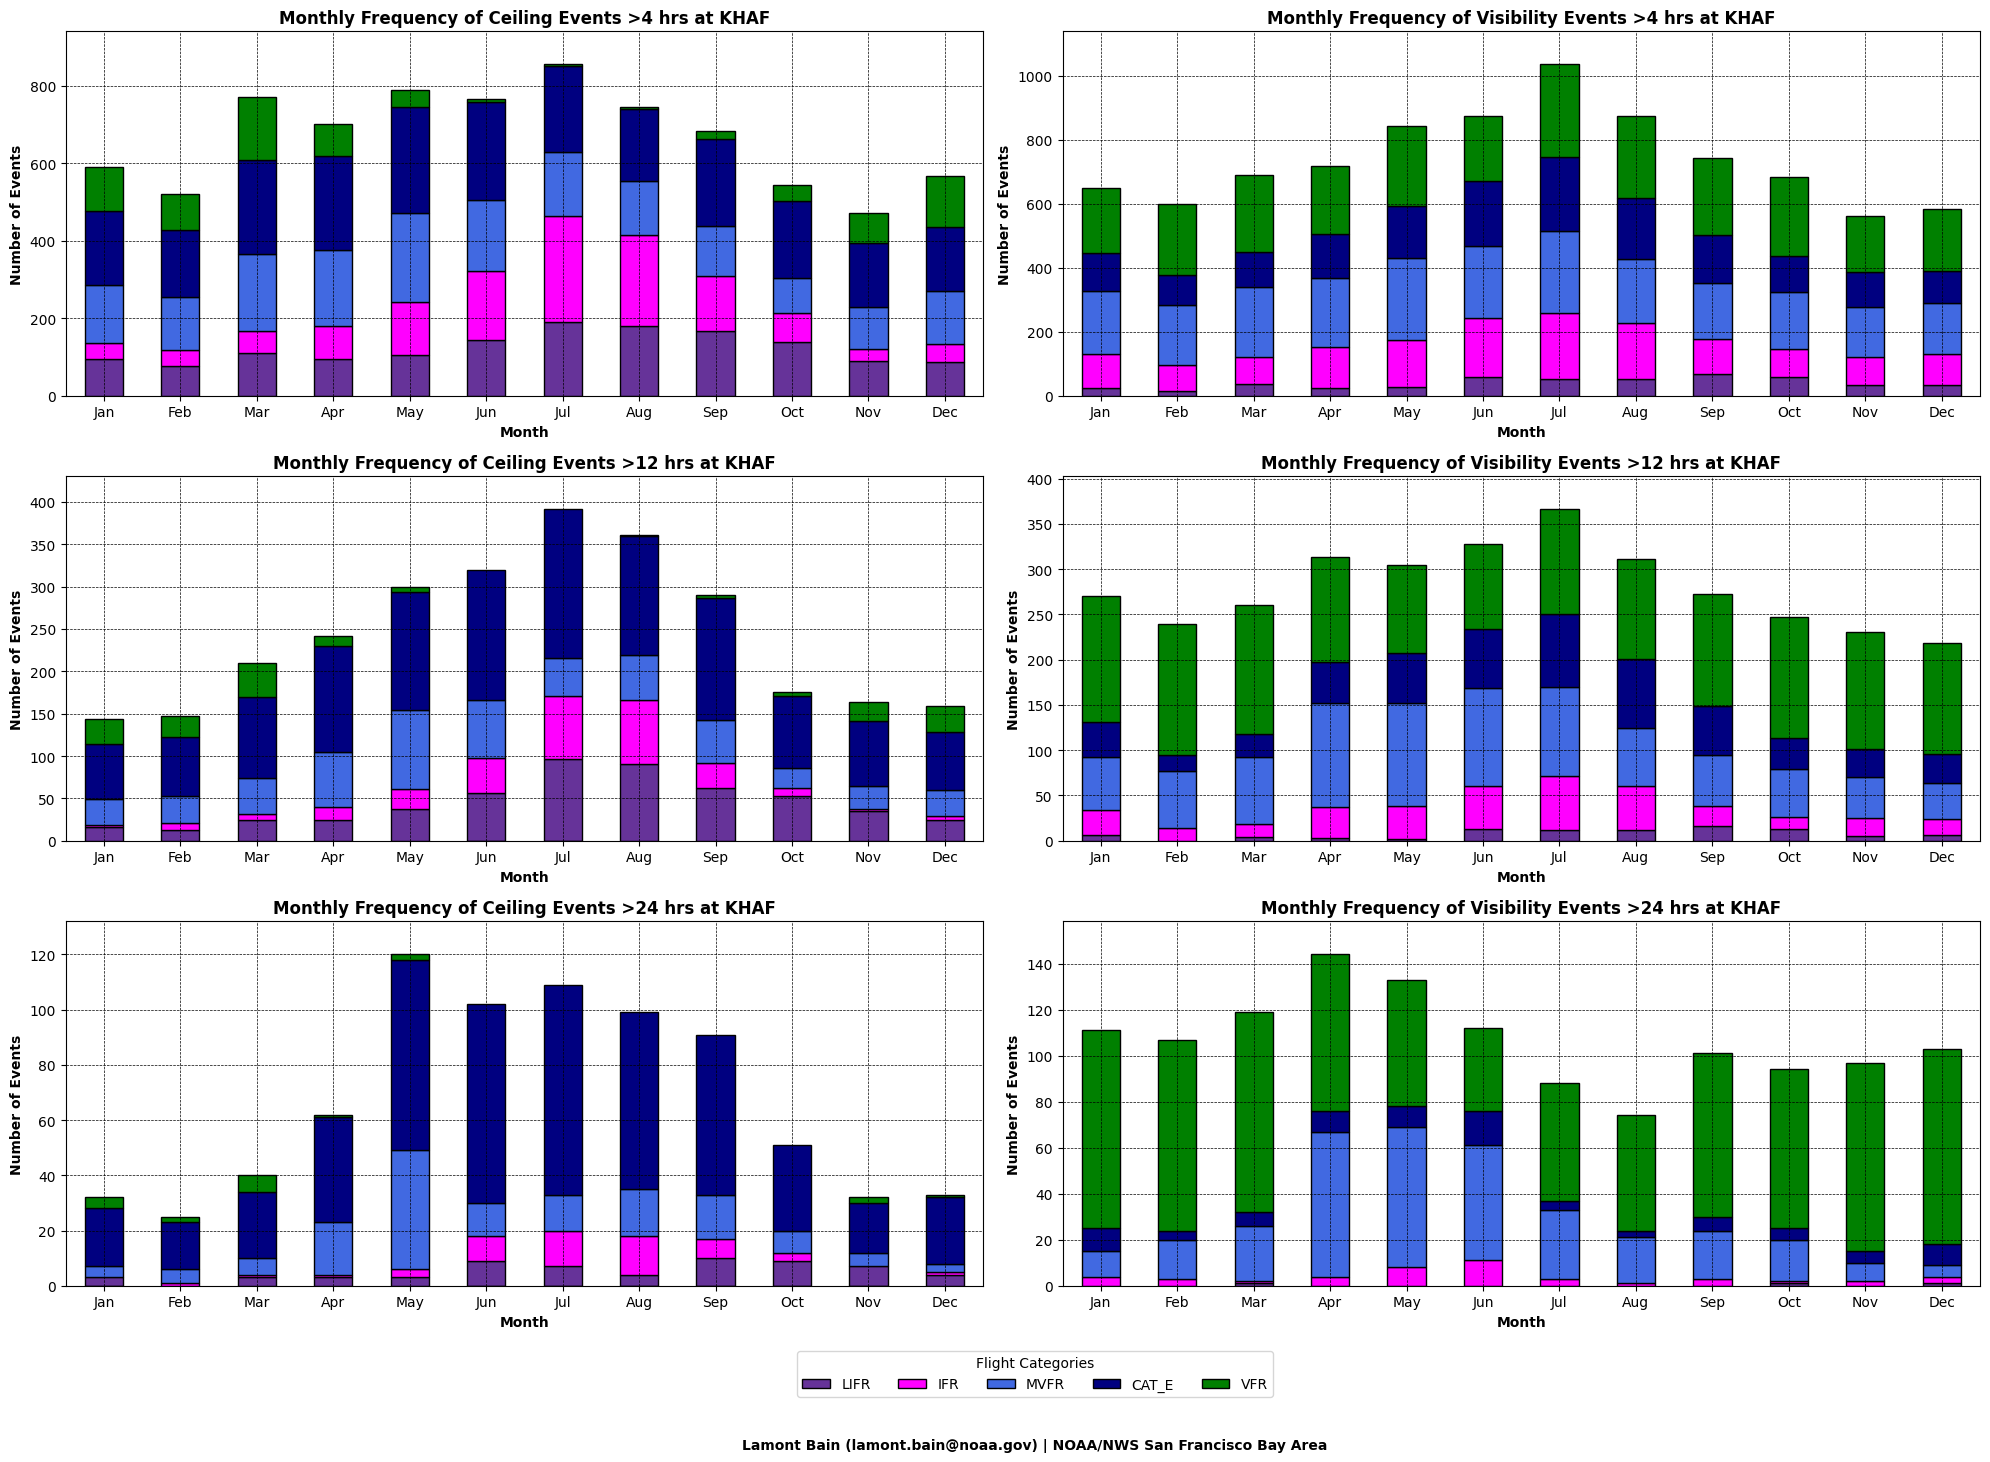

In [37]:
# @title Event Duration Frequency

# Durations for event filtering (in minutes)
event_durations = [240, 720, 1440]  # 4 hours, 12 hours, 24 hours
event_durations_hr = [int(dur / 60) for dur in event_durations]  # Convert to hours

# Dictionary to store filtered event data for each duration
cig_event_dur = {f'{dur}hr': {} for dur in event_durations_hr}
vis_event_dur = {f'{dur}hr': {} for dur in event_durations_hr}

# Iterate over the dictionaries and filter for each event duration
for key in cig_event_dfs:
    for dur, dur_hr in zip(event_durations, event_durations_hr):
        cig_event_dur[f'{dur_hr}hr'][key] = cig_event_dfs[key].query('event_duration_minutes > @dur')

for key in vis_event_dfs:
    for dur, dur_hr in zip(event_durations, event_durations_hr):
        vis_event_dur[f'{dur_hr}hr'][key] = vis_event_dfs[key].query('event_duration_minutes > @dur')

# Function to prepare monthly counts from event DataFrames
def prepare_monthly_counts(event_dfs):
    """ Prepare monthly counts from event DataFrames. """
    monthly_counts = {i: [] for i in range(1, 13)}  # Initialize a list for each month

    for category, df in event_dfs.items():
        counts = [0] * 12

        if not df.empty:  # Check to make sure that the dataframe isn't empty
            df.loc[:, 'month'] = df['start_time'].dt.month  # Extract month from start_time using .loc
            monthly_count = df['month'].value_counts().sort_index()  # Count events per month

            for month, count in monthly_count.items():
                counts[month - 1] = count  # month - 1 for zero-based index

        monthly_counts[category] = counts

    return pd.DataFrame(monthly_counts, index=range(1, 13), columns=event_dfs.keys()).fillna(0)

# Prepare monthly counts for ceiling and visibility events for each duration
ceiling_monthly_counts_4hr = prepare_monthly_counts(cig_event_dur['4hr'])
ceiling_monthly_counts_12hr = prepare_monthly_counts(cig_event_dur['12hr'])
ceiling_monthly_counts_24hr = prepare_monthly_counts(cig_event_dur['24hr'])

visibility_monthly_counts_4hr = prepare_monthly_counts(vis_event_dur['4hr'])
visibility_monthly_counts_12hr = prepare_monthly_counts(vis_event_dur['12hr'])
visibility_monthly_counts_24hr = prepare_monthly_counts(vis_event_dur['24hr'])

# Dynamically calculate ylim based on the maximum sum across all months for each event duration
max_ceiling_4hr = ceiling_monthly_counts_4hr.sum(axis=1).max() * 1.1  # Adding a 10% buffer
max_ceiling_12hr = ceiling_monthly_counts_12hr.sum(axis=1).max() * 1.1
max_ceiling_24hr = ceiling_monthly_counts_24hr.sum(axis=1).max() * 1.1

max_visibility_4hr = visibility_monthly_counts_4hr.sum(axis=1).max() * 1.1
max_visibility_12hr = visibility_monthly_counts_12hr.sum(axis=1).max() * 1.1
max_visibility_24hr = visibility_monthly_counts_24hr.sum(axis=1).max() * 1.1

# Create stacked bar plots
plt.clf()
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
plt.subplots_adjust(hspace=0.3)

# Plot ceiling and visibility events for each event duration (4hr, 12hr, 24hr)

# Stacked bar plot for ceiling events (4 hours)
ceiling_monthly_counts_4hr.plot(kind='bar', stacked=True, ax=ax[0, 0], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[0, 0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[0, 0].set_title(f'Monthly Frequency of Ceiling Events >4 hrs at {site.upper()}', fontweight='bold')
ax[0, 0].set_ylim(0, max_ceiling_4hr)

# Stacked bar plot for visibility events (4 hours)
visibility_monthly_counts_4hr.plot(kind='bar', stacked=True, ax=ax[0, 1], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[0, 1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[0, 1].set_title(f'Monthly Frequency of Visibility Events >4 hrs at {site.upper()}', fontweight='bold')
ax[0, 1].set_ylim(0, max_visibility_4hr)

# Stacked bar plot for ceiling events (12 hours)
ceiling_monthly_counts_12hr.plot(kind='bar', stacked=True, ax=ax[1, 0], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[1, 0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[1, 0].set_title(f'Monthly Frequency of Ceiling Events >12 hrs at {site.upper()}', fontweight='bold')
ax[1, 0].set_ylim(0, max_ceiling_12hr)

# Stacked bar plot for visibility events (12 hours)
visibility_monthly_counts_12hr.plot(kind='bar', stacked=True, ax=ax[1, 1], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[1, 1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[1, 1].set_title(f'Monthly Frequency of Visibility Events >12 hrs at {site.upper()}', fontweight='bold')
ax[1, 1].set_ylim(0, max_visibility_12hr)

# Stacked bar plot for ceiling events (24 hours)
ceiling_monthly_counts_24hr.plot(kind='bar', stacked=True, ax=ax[2, 0], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[2, 0].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[2, 0].set_title(f'Monthly Frequency of Ceiling Events >24 hrs at {site.upper()}', fontweight='bold')
ax[2, 0].set_ylim(0, max_ceiling_24hr)

# Stacked bar plot for visibility events (24 hours)
visibility_monthly_counts_24hr.plot(kind='bar', stacked=True, ax=ax[2, 1], lw=1.0, edgecolor='black', color=["rebeccapurple", "magenta", "royalblue", "navy", "green"], legend=False)
ax[2, 1].grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
ax[2, 1].set_title(f'Monthly Frequency of Visibility Events >24 hrs at {site.upper()}', fontweight='bold')
ax[2, 1].set_ylim(0, max_visibility_24hr)

# Set common labels for x-axis and y-axis
for axis_row in ax:
    for axis in axis_row:
        axis.set_xlabel('Month', fontweight='bold')
        axis.set_ylabel('Number of Events', fontweight='bold')
        axis.set_xticks(range(12))
        axis.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)






# Create a single horizontal legend below the bottom subplot
handles, labels = visibility_bars.get_legend_handles_labels()  # Get handles from the last plot
fig.legend(handles, labels, title='Flight Categories', bbox_to_anchor=(0.52, 0.08), loc='center', ncol=len(labels))
fig.text(0.52, 0.03, 'Lamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area', ha='center', fontsize=10, fontweight='bold')


plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit the legend
save_path = f'/content/drive/MyDrive/metar_archive/{site}/img/ceiling-visibility/'
save_filename = f'{save_path}{site}_monthly_frequency_cig_vis_dur_hr_events.png'
plt.savefig(save_filename)

plt.show()